<a href="https://colab.research.google.com/github/faikozcan/MLFraud/blob/main/CreditCardFraudDetection_European_cardholders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries

In [ ]:
#https://medium.com/ml-book/train-tf-keras-model-using-feature-coulmn-8de12e65ddec
import numpy as np
import pandas as pd
import requests 
import io
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column
import calendar
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve,precision_recall_curve
from keras.layers.advanced_activations import ReLU,LeakyReLU
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Lambda,Layer, Add, Multiply
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input,Dense,BatchNormalization,Dropout
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
from tensorflow.keras import backend as K 
from google.colab import drive
from sklearn.model_selection import train_test_split
import pickle
from unittest.mock import Mock
import tensorflow_probability as tfp

import math
import sys
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

_randomState=16
np.random.seed(_randomState) #keras backendclear
tf.random.set_seed(_randomState)#keras backendclear

np.set_printoptions(suppress=True)
np.set_printoptions(precision=10)

np.set_printoptions(threshold=np.inf, linewidth=200)

drive.mount('/content/drive')

# %load_ext tensorboard
%matplotlib inline

saveToFolder='/content/drive/MyDrive/CreditCardFraudDetection/Models/'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 5000)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Helper Functions

In [ ]:
from tabulate import tabulate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

def drawLossHistory(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def PlotModel(model):
  return plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True, expand_nested=True)

def getResults(key,model,predictions,actuals,settings,trainHistory,gs):
  
  precision =sklearn.metrics.precision_score(actuals,predictions)
  recall = sklearn.metrics.recall_score(actuals,predictions)
  roc = sklearn.metrics.roc_auc_score(actuals,predictions)
  f1 = sklearn.metrics.f1_score(actuals,predictions) #2*precision*recall/(precision+recall)
  trainEpochCount =len(trainHistory['loss'])

  strPrecision='{0:.2f}'.format(precision)
  strRecall='{0:.2f}'.format(recall)
  strRoc='{0:.2f}'.format(roc)
  strF1='{0:.2f}'.format(f1)
  if(key!='rf'):
    paramCount=model.count_params()
  else:
    paramCount=None
  tblData =[[model._name,str(paramCount),str(trainEpochCount),strPrecision, strRecall,strRoc,strF1,'{}/{}'.format(gs['trainDataCountPositives'],gs['trainDataCount']),'{}/{}'.format(len(actuals[actuals==1]),len(actuals)),test_ratio,gs['PositionalEncoding'] ,settings['oversamplingRate'],settings['oversamplingMethod']]]
  return pd.DataFrame(tblData, columns=["ModelName","ParamCount","TrainEpochs","Precision","Recall","AUC Score","F1","TrainDataCount","TestDataCount","Test/Train Ratio","Pos.Enc.","OversamplingRate","Oversampling"])



def drawROCCurve(y_Real,y_Predicted,name,savePath=None):

  false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_Real, y_Predicted)
  auc =sklearn.metrics.roc_auc_score(y_Real, y_Predicted)
  f1=np.round(sklearn.metrics.f1_score(y_Real,y_Predicted),2)
  recall=np.round(sklearn.metrics.recall_score(y_Real,y_Predicted),2)
  precision=np.round(sklearn.metrics.precision_score(y_Real,y_Predicted),2)

  sns.set(font_scale=1.2)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios': [1, 1]})
  fig.suptitle(name)
  ax1.set_title('ROC curve AUC = %.2f'%auc+'  F1 Score:%.2f'%f1)

  ax1.plot(false_positive_rate1, true_positive_rate1)
  ax1.plot([0, 1], ls="--")
  ax1.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  ax1.set_ylabel('True Positive Rate')
  ax1.set_xlabel('False Positive Rate')

  # ax2.set_title(name)
  cm = confusion_matrix(y_Predicted, y_Real)
  ax2 = sns.heatmap(cm, annot=True, fmt="d")
  ax2.set_ylabel('Predicted')
  ax2.set_xlabel('Actual')
  ax2.set_title('Precision: %.2f'%precision + ' Recall:%.2f'%recall )
  if not savePath is None:
    fig.savefig(savePath, dpi=100)
  return plt

def PredictEvalAndSave(model,foldCount,saveToFolder, save=True):
  testLabels=test['class']
  autoEncoderSeperatedTestX = test[allColumns]
  autoEncoderSeperatedTestY = test['class']
  resultPredict=model.predict(autoEncoderSeperatedTestX)
  resultPredict[0] = ( resultPredict[0] > 0.5)
  precision ="{0:.2f}".format(sklearn.metrics.precision_score(testLabels,resultPredict[0]))
  recall ="{0:.2f}".format(sklearn.metrics.recall_score(testLabels,resultPredict[0]))

  autoEncoderSeperatedTestNumericDecoding = test[continuous_feature_Columns]
  autoEncoderSeperatedTestCategoricalDecoding = test[categorical_feature_Columns]
  resultsEval = autoEncoderModelSeperated.evaluate(autoEncoderSeperatedTestX,[autoEncoderSeperatedTestY,autoEncoderSeperatedTestNumericDecoding,autoEncoderSeperatedTestCategoricalDecoding])
  metricData = pd.DataFrame(np.array([resultsEval]),
                    columns=autoEncoderModelSeperated.metrics_names)
  name=model.name
  loss="{0:.2f}".format(metricData['classifier_loss'][0])
  name=name + F"_f1{foldCount}"
  model._name=name
  if not os.path.exists(saveToFolder):
    os.makedirs(saveToFolder)
  plot_model(autoEncoderModelSeperated, to_file=F"{saveToFolder}/modelStructure.png", show_shapes=True)
  
  htmlString = "<html><body>"+ metricData.to_html()+ "</body></html>"
  with open(F"{saveToFolder}/EvaluationResults.html", 'w') as f:
       f.write(htmlString)
  with open(F"{saveToFolder}/modelsummary.txt", 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
  if (save):
    model.save(F"{saveToFolder}/{name}.h5",overwrite=True)
  confusionSavePath=F"{saveToFolder}/confusion.png"
  DrawConsufionTable(resultPredict[0],TestLabels,name,confusionSavePath)


def Draw3DPlot(ax,components,targets,title):
  df = pd.DataFrame(data = np.concatenate([components,targets],axis=1)
                , columns = ['c1', 'c2', 'c3','target'])
  

  ax.set_title(title)
  ax.set_xlabel('Principal Component 1', fontsize = 12)
  ax.set_ylabel('Principal Component 2', fontsize = 12)
  ax.set_zlabel('Principal Component 3', fontsize = 12)
  colors = ['r', 'g']
  labels = [1, 0]
  for target, color in zip(labels,colors):
      indicesToKeep = df['target'] == target
      ax.scatter3D(df["c1"].loc[indicesToKeep]
                ,df["c2"].loc[indicesToKeep]
                ,df["c3"].loc[indicesToKeep]
                , c = color
                ,s=10
                )
  ax.grid()
  ax.view_init(25,20)

def Draw2DPlot(ax,components,targets,title=''):
    df = pd.DataFrame(data = np.concatenate([components,targets],axis=1)
                , columns = ['c1', 'c2','target'])


    ax.set_title(title)
    ax.set_xlabel('Principal Component 1', fontsize = 12)
    ax.set_ylabel('Principal Component 2', fontsize = 12)
    colors = ['r', 'g']
    labels = [1, 0]
    for target, color in zip(labels,colors):
      indicesToKeep = df['target'] == target
      ax.scatter(df["c1"].loc[indicesToKeep]
                ,df["c2"].loc[indicesToKeep]
                , c = color
                ,s=10
                )
    ax.grid()


    # ax.set_title(title)
    # ax.scatter(components[np.where(targets == 0), 0], components[np.where(targets == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    # ax.scatter(components[np.where(targets == 1), 0], components[np.where(targets == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')
    # plt.legend(loc='best');
    
    

def overSampleData(dataX,dataY,method,_oversamplingRate,random_state):
  if  (method=='SMOTE'):
    over = SMOTE(sampling_strategy=_oversamplingRate,random_state=random_state)
    steps = [('o', over)]
    pipeline = Pipeline(steps=steps)
    X_train_res, y_train_res = pipeline.fit_resample(dataX, dataY.ravel())
  else:
    if (method=='Random'):
      oversampler = RandomOverSampler(_oversamplingRate,random_state=random_state)
      X_train_res,y_train_res=oversampler.fit_resample(dataX,dataY)
  return X_train_res,y_train_res

def getInputExtended(array):
    cos2piArray= np.cos(2*math.pi*array)
    cos4piArray= np.cos(4*math.pi*array)
    sin2piArray=  np.sin(2*math.pi*array)
    sin4piArray= np.sin(4*math.pi*array)
    array=np.concatenate((array, cos2piArray, sin2piArray,cos4piArray,sin4piArray),axis=1)#,
    #array=np.concatenate((array, cos2piArray, cos4piArray,sin2piArray,sin4piArray),axis=1)

    return array

def ApplyPositionalEncoding(xt):
  inputArray=np.array(xt)
  inputArray=getInputExtended(inputArray)
  return inputArray


def createUnderSampledTestSet(random_state):
  underSampler = RandomUnderSampler(random_state=random_state,ratio=1)
  x,y=underSampler.fit_resample(testX,testY)
  return x,y

def EvalAndPrint(model, valX,valY, printDf=True):
  scores=model.evaluate(valX,valY,verbose=0)
  evalResult = pd.DataFrame(np.array([scores]), columns=model.metrics_names)
  precision=evalResult['classifier_precision']
  recall=evalResult['classifier_recall']

  loss= evalResult['loss'] 
  decoder_loss=evalResult['decoder_loss']
  classifier_loss=evalResult['classifier_loss']
  f1 = np.round(2*precision*recall/(precision+recall+K.epsilon()),3)
  evalResult["F1"]=f1
  summaryResult=pd.DataFrame([[loss,decoder_loss,classifier_loss,np.round(precision,3),np.round(recall,3),np.round(f1,3)]], columns=['Loss','DecoderLoss','ClassifierLoss','Precision','Recall','F1'],index=None)
  if (printDf==True):
   print(tabulate(summaryResult,headers='keys', tablefmt='fancy_grid'))
  return summaryResult
  

# Load Data

In [ ]:
from typing import DefaultDict
df = pd.read_csv(F"/content/drive/My Drive/Data/creditcard.csv") #unzip and read in data downloaded to the local directory
df.head(n=5) #just to check you imported the dataset properly

# df.drop_duplicates(keep='first',inplace=True) 
# duplicateRowsDF= df[df.duplicated(keep='first')]
# print("All Duplicate Rows based on all columns are :")
# print(duplicateRowsDF)


# Memory Reduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df=reduce_mem_usage(df)


Mem. usage decreased to 17.11 Mb (74.6% reduction)


##Time Column

In [ ]:
df_norm = df.copy()
df_norm["Time"]= (df["Time"] % 86400) / 3600 # Convert seconds to hour by getting the mod with seconds of day, then floor it to take it same for decimal point hours , 2:20 will be same as 2
df_norm["time_norm"] = 2 * math.pi * np.floor(df_norm["Time"]) /24

df_norm.insert(0,'Time_Sin', np.sin(df_norm["time_norm"]))
df_norm.insert(0,'Time_Cos', np.cos(df_norm["time_norm"]))

df_norm.drop(['time_norm'],axis=1,inplace=True)
df_norm.drop(['Time'], axis=1,inplace=True)
# df_norm.drop(['Amount'],axis=1,inplace=True)
df_norm.head(5)


,Time_Cos,Time_Sin,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.0,0.0,-1.359375,-0.072754,2.537109,1.377930,-0.338379,0.462402,0.239624,0.098694,0.363770,0.090820,-0.551758,-0.617676,-0.991211,-0.311279,1.467773,-0.470459,0.208008,0.025787,0.404053,0.251465,-0.018311,0.277832,-0.110474,0.066956,0.128540,-0.189087,0.133545,-0.021057,149.625000,0
1,1.0,0.0,1.191406,0.266113,0.166504,0.448242,0.060028,-0.082336,-0.078796,0.085083,-0.255371,-0.166992,1.612305,1.065430,0.489014,-0.143799,0.635742,0.463867,-0.114807,-0.183350,-0.145752,-0.069092,-0.225830,-0.638672,0.101318,-0.339844,0.167114,0.125854,-0.008980,0.014725,2.689453,0
2,1.0,0.0,-1.358398,-1.339844,1.773438,0.379883,-0.503418,1.800781,0.791504,0.247681,-1.514648,0.207642,0.624512,0.066101,0.717285,-0.165894,2.345703,-2.890625,1.110352,-0.121338,-2.261719,0.524902,0.248047,0.771484,0.909180,-0.689453,-0.327637,-0.139038,-0.055359,-0.059753,378.750000,0
3,1.0,0.0,-0.966309,-0.185181,1.792969,-0.863281,-0.010307,1.247070,0.237549,0.377441,-1.386719,-0.054962,-0.226440,0.178223,0.507812,-0.287842,-0.631348,-1.059570,-0.684082,1.965820,-1.232422,-0.208008,-0.108276,0.005272,-0.190308,-1.175781,0.647461,-0.221924,0.062744,0.061462,123.500000,0
4,1.0,0.0,-1.158203,0.877930,1.548828,0.403076,-0.407227,0.095947,0.592773,-0.270508,0.817871,0.752930,-0.822754,0.538086,1.345703,-1.120117,0.175171,-0.451416,-0.237061,-0.038208,0.803711,0.408447,-0.009430,0.798340,-0.137451,0.141235,-0.206055,0.502441,0.219482,0.215210,70.000000,0


##Show Class Counts

In [ ]:
vc = df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(df), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Credit Card Fraud Class Distribution')]

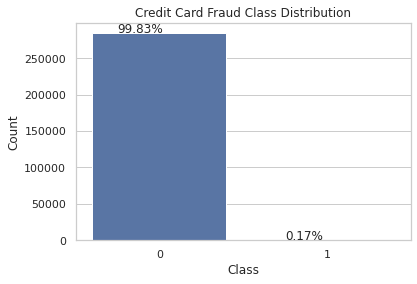

In [ ]:
#### Plot the Distribution and log image on Neptune
sns.set(style="whitegrid")
ax = sns.countplot(x="Class", data=df)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(df)*100), (p.get_x()+0.15, p.get_height()+1000))
ax.set(ylabel='Count', 
       title='Credit Card Fraud Class Distribution')


#Scale

In [ ]:
dataX=df_norm.drop(['Class'], axis=1) #drop the class column
dataY=df_norm["Class"].values
dataX=dataX.values


_scaling='MinMax'#Standart

if (_scaling=='MinMax'):
  scaler=MinMaxScaler(feature_range=(0, 1))
else:
  if (_scaling=='Standart'):
      scaler=StandardScaler()
scaler.fit(dataX)
dataX=scaler.transform(dataX)


# Split 

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

#validation_ratio = 0.05
test_ratio = 0.20

#not used when stratified kfold used
trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size= test_ratio,stratify=dataY, shuffle=True,random_state=42) #%20 of dataset is seperated

#trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=validation_ratio,random_state=42) # Remaining datasets %10 is seperated for validation

trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

#validationX = scaler.transform(validationX)

print('Training Data:',Counter(trainY))
print('Test Data:',Counter(testY))
# print('Validation Data:',Counter(validationY))

Training Data: Counter({0: 226602, 1: 378})
Test Data: Counter({0: 56651, 1: 95})


In [ ]:
pd.DataFrame(trainX).head(10)
print(trainX.shape)

(226980, 31)


#Manuel PCA

In [ ]:
from sklearn.decomposition import PCA

r = np.random.RandomState(_randomState)

indices = np.where(trainY==0)
normalIndexes = r.choice(indices[0], size=5000, replace=False)

indices = np.where(trainY==1)
frdIndexes =r.choice(indices[0], size=200 , replace=False)

concatIndexes=np.concatenate([frdIndexes,normalIndexes])

ax=np.array(trainX)[concatIndexes]
ay=np.array(trainY)[concatIndexes]

#axp,ayp=ApplyPositionalEncoding(ax,ay)

pca=PCA(n_components=2)
df_pcax  = pca.fit_transform(ax)

Draw2DPlot(df_pcax,ay)
pca=PCA(n_components=3)
df_pcax  = pca.fit_transform(ax)
Draw3DPlot(df_pcax,ay.reshape(-1,1))


# #Manual way without using transform
# trainX_mean = trainX - np.mean(trainX, axis = 0) 
# print(pd.DataFrame(trainX_mean[:5,:]))
# r= np.dot(trainX_mean,pca.components_.T).round(2)
# print('Manually Transformed Data:\n',pd.DataFrame(r[:2,:]))
# print('components',pca.components_)
# # plt.plot(np.cumsum(pca.explained_variance_ratio_))
# # plt.rcParams["figure.figsize"] = (20,10)
# # plt.xlim(0,31,1)
# # plt.xlabel('Number of components')
# # plt.ylabel('Cumulative explained variance')

#Apply PCA or T-SNE

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

pca = PCA(n_components=3)
r = np.random.RandomState(_randomState)

indices = np.where(testY==0)
normalIndexes = r.choice(indices[0], size=1000, replace=False)

indices = np.where(testY==1)
frdIndexes =r.choice(indices[0], size=95, replace=False)

concatIndexes=np.concatenate([frdIndexes,normalIndexes])

trainXSamples=np.array(testX)[concatIndexes]
trainYSamples=np.array(testY)[concatIndexes]

pca_result = pca.fit_transform(trainXSamples)
print(pca.explained_variance_ratio_)
Draw3DPlot(pca_result,trainYSamples.reshape(-1,1))

tsne = TSNE(n_components=3, verbose=1)
tsneResult = tsne.fit_transform(trainXSamples) 
Draw3DPlot(tsneResult,trainYSamples.reshape(-1,1))



# Model Helper Functions

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# _patience=3

# earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", 
#                                          patience = _patience)

def TrainRandomForest(X,Y):
  parameters = {
          'n_estimators': 50,  
          'min_samples_split':20
          }
  modelRF=None
  modelRF = RandomForestClassifier(**parameters)
  modelRF._name='RandomForest'
  modelRF.fit(X,Y.ravel())
  
  return modelRF


def TrainMLP(X,Y,valX,valY,neuronCountsForClassifier):
  deepModel=None
  deepModel=get_MLP(X.shape[1],neuronCounts=neuronCountsForClassifier)
  deepModel._name='MLP' + '_inShape_' +str(X.shape[1]) + '_' +   '_'.join([str(elem) for elem in neuronCountsForClassifier]),
  Y=np
  history = deepModel.fit (X,	y={"classifier": Y},
                  #validation_data=(valX,{ "classifier": valY}),
                  epochs=_maxEpochs,
                  verbose=_verbose,
                  batch_size=_batch_size,
                  # callbacks=[earlystopping]
              )
  return deepModel,history.history

  
def trainModelForFold(model,requestedFold,epoch=15,_batch_size=200):
  currentFoldNumer=-1
  _kFoldCount=5
  cv = StratifiedKFold(n_splits=_kFoldCount, random_state = _randomState, shuffle=True)
  history=None
  for train_indexes,validation_indexes in cv.split(dataX,dataY):
        currentFoldNumer=currentFoldNumer+1
        if(currentFoldNumer==requestedFold):
            print("Training With Fold:",currentFoldNumer)
            X,Y = dataX[train_indexes],dataY[train_indexes]
            Y=Y.astype(float).reshape(-1,1)

            X=ApplyPositionalEncoding(X)
            history = model.fit (X,	y= [X ,Y ],
                                                            #validation_data=(valX,{"decoder":valX,'classifier':valY}),
                                                            epochs=epoch,
                                                            verbose=1,
                                                            batch_size=_batch_size)
  return history.history

def splitFolds(foldNumber,_kFoldCount,_randomState):
    cv = StratifiedKFold(n_splits=_kFoldCount, random_state = _randomState, shuffle=True)
    currentFoldNumer=-1
    for train_indexes,validation_indexes in cv.split(dataX,dataY):
       currentFoldNumer=currentFoldNumer+1
       if (currentFoldNumer==foldNumber):
          valX,valY = dataX[validation_indexes],dataY[validation_indexes]
          trainX,trainY = dataX[train_indexes],dataY[train_indexes]
          valX=ApplyPositionalEncoding(valX)
          trainX=ApplyPositionalEncoding(trainX)
          return trainX,trainY,valX,valY
    return None,None,None,None

def testModelForFold(model,foldNumber,rocCurve=False,printResults=True):
  print('RandomState:',_randomState)
  _kFoldCount=5
  currentFoldNumer=-1
  cv = StratifiedKFold(n_splits=_kFoldCount, random_state = _randomState, shuffle=True)
  dfResults=pd.DataFrame()
  for train_indexes,validation_indexes in cv.split(dataX,dataY):
    currentFoldNumer=currentFoldNumer+1
    if(currentFoldNumer==foldNumber):
      print("Testing With Fold:",currentFoldNumer)
      valX,valY = dataX[validation_indexes],dataY[validation_indexes]
      valX=ApplyPositionalEncoding(valX)
      if (rocCurve):
          predictions =model.predict(valX)
          predictions = sklearn.preprocessing.binarize(predictions[1],  threshold=0.5, copy=True)
          drawROCCurve(valY,predictions,'',savePath=None)
      else:
        rEvaluation= EvalAndPrint(model,valX,valY,False)
        dfResults=pd.concat([dfResults,rEvaluation], axis=0,ignore_index=True)
     
  if(rocCurve==False):
    dfResults=dfResults.sort_values(by=['F1'], ascending=False,ignore_index=True)
    # print("Mean F1 :" ,np.round(dfResults['F1'].mean(),2))
    # print("Mean F1 :" ,np.round(dfResults['F1'].std(),2))
  if (printResults==True):
    print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))
    print('Mean Results')
    print(tabulate([np.round(dfResults.mean(),2)], headers='keys', tablefmt='fancy_grid'))
    print('Standart Deviation Results')
    print(tabulate([np.round(dfResults.std(),2)], headers='keys', tablefmt='fancy_grid'))
  return dfResults



def testModelForTrainingFolds(model,exceptFoldNumber):
  print('RandomState:',_randomState)
  _kFoldCount=5
  currentFoldNumer=-1
  cv = StratifiedKFold(n_splits=_kFoldCount, random_state = _randomState, shuffle=True)
  dfResults=pd.DataFrame()
  for train_indexes,validation_indexes in cv.split(dataX,dataY):
      currentFoldNumer=currentFoldNumer+1
      if(currentFoldNumer==exceptFoldNumber):
        valX,valY = dataX[train_indexes],dataY[train_indexes]
        print('Data shape:',valX.shape)
        valX=ApplyPositionalEncoding(valX)
        predictions =model.predict(valX)
        predictions = sklearn.preprocessing.binarize(predictions[1],  threshold=0.5, copy=True)
        rEvaluation= EvalAndPrint(model,valX,valY,False)
        dfResults=pd.concat([dfResults,rEvaluation], axis=0,ignore_index=True)
        break;
  
  return dfResults


#Model Creator Functions

In [ ]:
def get_Auto_Encoder_Vanilia(numInputColumns,neuronCountsForEncoder=[],latent_dim=0):
  inputLayer = Input(shape = (numInputColumns,))
  _name='VaniliaAE' # + '_in_' +str(numInputColumns) +  '_enc_' + '_'.join([str(elem) for elem in neuronCountsForEncoder]) + '_ldim_' + str(latent_dim) +  '_cls_' + '_'.join([str(elem) for elem in neuronCountsForClassifier]) 
  _noiseStd=0.05
  x=tf.keras.layers.GaussianNoise(_noiseStd,seed=_randomState,name=F"gaussian_noise_{_noiseStd}_seed_{_randomState}")(inputLayer)
  counter=0
  # Iteratively add the hidden layers
  for n_neurons in neuronCountsForEncoder:
      counter=counter+1
      x = tf.keras.layers.Dense(n_neurons)(x)
      x = tf.keras.layers.ReLU()(x)

      if(counter==1):
        x = tf.keras.layers.BatchNormalization()(x)

  zLatentLayer = Dense(latent_dim, name="z_Latent")(x)
  encoder = tf.keras.models.Model(inputLayer,zLatentLayer,name='encoder')
  dIn= tf.keras.layers.Input(shape=(latent_dim,), name='decoder_input')
  d=dIn 
  counter=0
  for n_neurons in reversed(neuronCountsForEncoder):
      counter=counter+1
      d = tf.keras.layers.Dense(n_neurons)(d)
      d = tf.keras.layers.ReLU()(d)

      if(counter==1):
         d =tf.keras.layers.BatchNormalization()(d)

  dOut  = tf.keras.layers.Dense(numInputColumns, activation='relu')(d)
  decoder = tf.keras.models.Model(dIn,  dOut, name= 'decoder')
 
  zOut=encoder(inputLayer)
  decoderOut=decoder(zOut)

  autoEncoderModel = tf.keras.models.Model(inputLayer,[decoderOut], name=_name)
  autoEncoderModel.compile(loss={
                                 'decoder':'mse'
                              },
                        optimizer=tf.keras.optimizers.Adam())
  return autoEncoderModel,encoder,decoder



def get_Auto_Encoder_With_Classifier(numInputColumns,latent_dim=0,neuronCountsForClassifier=[],neuronCountsForEncoder=[]):
  inputLayer = Input(shape = (numInputColumns,))
  _name='SemiSupervisedAEWithClassifier' # + '_in_' +str(numInputColumns) +  '_enc_' + '_'.join([str(elem) for elem in neuronCountsForEncoder]) + '_ldim_' + str(latent_dim) +  '_cls_' + '_'.join([str(elem) for elem in neuronCountsForClassifier]) 
  _noiseStd=0.05
  x=tf.keras.layers.GaussianNoise(_noiseStd,seed=_randomState,name=F"gaussian_noise_{_noiseStd}_seed_{_randomState}")(inputLayer)
  counter=0
  # Iteratively add the hidden layers
  for n_neurons in neuronCountsForEncoder:
      counter=counter+1
      x = tf.keras.layers.Dense(n_neurons)(x)
      x = tf.keras.layers.ReLU()(x)

      if(counter==1):
        x = tf.keras.layers.BatchNormalization()(x)

  zLatentLayer = Dense(latent_dim, name="z_Latent")(x)
  encoder = tf.keras.models.Model(inputLayer,zLatentLayer,name='encoder')

  clsInput = tf.keras.layers.Input(shape=(latent_dim,), name='classifier_input')
  c=clsInput
  counter=0
  for n_neurons in neuronCountsForClassifier:
    counter=counter+1
    c = tf.keras.layers.Dense(n_neurons)(c)
    c = tf.keras.layers.ReLU()(c)
    if(counter==1):
      c =tf.keras.layers.Dropout(0.10)(c)
       
  cOut = Dense(1, activation='sigmoid')(c)

  classifier = tf.keras.models.Model(clsInput, cOut, name='classifier')

  dIn= tf.keras.layers.Input(shape=(latent_dim,), name='decoder_input')
  d=dIn 
  counter=0
  for n_neurons in reversed(neuronCountsForEncoder):
      counter=counter+1
      d = tf.keras.layers.Dense(n_neurons)(d)
      d = tf.keras.layers.ReLU()(d)

      if(counter==1):
         d =tf.keras.layers.BatchNormalization()(d)

  dOut  = tf.keras.layers.Dense(numInputColumns, activation='relu')(d)
  decoder = tf.keras.models.Model(dIn,  dOut, name= 'decoder')
 

  zOut=encoder(inputLayer)
  classifierOut = classifier(zOut)
  decoderOut=decoder(zOut)

  autoEncoderModel = tf.keras.models.Model(inputLayer,[decoderOut,classifierOut], name=_name)
  autoEncoderModel.compile(loss={
                                 'decoder':'mse',
                                 'classifier':'binary_crossentropy'
                              },
                        
                       metrics={'classifier': 
                                  [
                                  tf.keras.metrics.TruePositives(name='tp'),
                                  tf.keras.metrics.FalsePositives(name='fp'),
                                  tf.keras.metrics.TrueNegatives(name='tn'),
                                  tf.keras.metrics.FalseNegatives(name='fn'), 
                                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                  tf.keras.metrics.Precision(name='precision'),
                                  tf.keras.metrics.Recall(name='recall'),
                                  tf.keras.metrics.AUC(name='auc'),
                                  ]
                               },
                        optimizer=tf.keras.optimizers.Adam())
  return autoEncoderModel,encoder,decoder



class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def get_Variational_Encoder_WithClassifier(numInputColumns,latent_dim=0,neuronCountsForClassifier=[],neuronCountsForEncoder=[]):

  inputLayer = Input(shape = (numInputColumns,))
  _noiseStd=0.001
  x=tf.keras.layers.GaussianNoise(_noiseStd,seed=_randomState,name=F"gaussian_noise{_noiseStd}")(inputLayer)
  x=inputLayer
  counter=0
  # Iteratively add the hidden layers
  for n_neurons in neuronCountsForEncoder:
      counter=counter+1
      x = Dense(n_neurons)(x)
      x = ReLU()(x)
      if(counter==1):
        x = BatchNormalization()(x)

  z_mean = tf.keras.layers.Dense(latent_dim, name='mean')(x)
  z_log_var = tf.keras.layers.Dense(latent_dim, name='log_variance')(x)
  z = Sampling()((z_mean, z_log_var))
  encoder = tf.keras.Model(inputs=inputLayer, outputs=z, name="encoder")

  dIn= tf.keras.layers.Input(shape=(latent_dim,), name='decoder_input')
  d=dIn
  counter=0
  for n_neurons in reversed(neuronCountsForEncoder):
    counter=counter+1
    d = Dense(n_neurons)(d)
    d = ReLU()(d)
    if(counter==1):
         d =tf.keras.layers.BatchNormalization()(d)
 
  dOut  = Dense(numInputColumns, activation='relu')(d)
  decoder = Model(dIn, dOut, name='decoder')

  clsInput = tf.keras.layers.Input(shape=(latent_dim,), name='classifier_input')
  c=clsInput
  counter=0
  for n_neurons in neuronCountsForClassifier:
    counter=counter+1
    c = Dense(n_neurons)(c)
    c = ReLU()(c)
    if(counter==1):
      c =tf.keras.layers.Dropout(0.10)(c)
  cOut = Dense(1, activation='sigmoid')(c)
  classifier = Model(clsInput, cOut, name='classifier')

  # instantiate VAE model
  encodedOut = encoder(inputLayer)

  decoded = decoder(encodedOut)
  classifierOut = classifier(encodedOut)

  autoEncoderModel = Model(inputLayer,[decoded,classifierOut], name='vae')
  kl_loss = K.mean(- 0.5 * 1/latent_dim * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
  autoEncoderModel.add_loss(kl_loss)
  autoEncoderModel.add_metric(kl_loss, name='kl_loss', aggregation='mean')

  autoEncoderModel._name ='VariationalAutoEncoder'  + '_'.join([str(elem) for elem in neuronCountsForEncoder]) 
  autoEncoderModel.compile(loss={
                                 'classifier':'binary_crossentropy',
                                 'decoder':'mse',
                                
                              },
                       metrics={'classifier': 
                                  [
                                  tf.keras.metrics.TruePositives(name='tp'),
                                  tf.keras.metrics.FalsePositives(name='fp'),
                                  tf.keras.metrics.TrueNegatives(name='tn'),
                                  tf.keras.metrics.FalseNegatives(name='fn'), 
                                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                  tf.keras.metrics.Precision(name='precision'),
                                  tf.keras.metrics.Recall(name='recall'),
                                  tf.keras.metrics.AUC(name='auc'),
                                  ]
                               },
                       optimizer=tf.keras.optimizers.Adam())
  return autoEncoderModel,encoder,decoder



def get_MLP(inputShape, neuronCounts=[]):
    model_save_name ='Deep_'  + '_'.join([str(elem) for elem in neuronCounts])  
    inputLayer = Input(shape = (inputShape,))
    x=inputLayer
    counter=0
    # Iteratively add the hidden layers
    for n_neurons in neuronCounts:
        counter=counter+1
        x = Dense(n_neurons)(x)
        x = ReLU()(x)
        # if(counter==1):
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

    classifier_output = Dense(1, activation='sigmoid', name='classifier')(x)
    model = Model(inputs=[inputLayer], outputs=[classifier_output], name=model_save_name)
    model.compile(loss={'classifier': 'binary_crossentropy'},
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics={'classifier': 
                                  [
                                  tf.keras.metrics.TruePositives(name='tp'),
                                  tf.keras.metrics.FalsePositives(name='fp'),
                                  tf.keras.metrics.TrueNegatives(name='tn'),
                                  tf.keras.metrics.FalseNegatives(name='fn'), 
                                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                  tf.keras.metrics.Precision(name='precision'),
                                  tf.keras.metrics.Recall(name='recall'),
                                  tf.keras.metrics.AUC(name='auc'),
                                  ]
                               })
    return model




#BAYESIAN NEURAL
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def get_bnn(inputShape,trainSize,batchSize,neuronCounts=[]):
    inputLayer = Input(shape = (inputShape,))
    x=inputLayer
    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for n_neurons in neuronCounts:
        x = tfp.layers.DenseVariational(
            units=n_neurons,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / (trainSize/batchSize),
            activation="sigmoid",
        )(x)

    # The output is deterministic: a single point estimate.
    classifier_output = Dense(1, activation='sigmoid', name='classifier')(x)
    model = Model(inputs=[inputLayer], outputs=[classifier_output], name='Bayesian Neural Network')  
    model.compile(loss={'classifier': 'binary_crossentropy'},
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics={'classifier': 
                                  [
                                  tf.keras.metrics.TruePositives(name='tp'),
                                  tf.keras.metrics.FalsePositives(name='fp'),
                                  tf.keras.metrics.TrueNegatives(name='tn'),
                                  tf.keras.metrics.FalseNegatives(name='fn'), 
                                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                  tf.keras.metrics.Precision(name='precision'),
                                  tf.keras.metrics.Recall(name='recall'),
                                  tf.keras.metrics.AUC(name='auc'),
                                  ]
                               })  
    return model

# VAR AUTO

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self,**kwargs):
        super(Sampling,self).__init__(**kwargs)
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



def getVEncoder(numInputColumns,layerNeuronCounts,latentDim):
    """Defines the encoder model with the Sampling layer
    Args:
      latent_dim -- dimensionality of the latent space
      input_shape -- shape of the dataset batch

    Returns:
      model -- the encoder model
    """
    inputs = tf.keras.layers.Input(shape=(numInputColumns,), name='encoder_input')
    x=inputs
    counter=0
    # Iteratively add the hidden layers
    for n_neurons in layerNeuronCounts:
        counter=counter+1
        x = Dense(n_neurons)(x)
        x = ReLU()(x)
        if(counter==1):
          x = BatchNormalization()(x)

    mu = tf.keras.layers.Dense(latentDim, name='mean')(x)
    sigma = tf.keras.layers.Dense(latentDim, name='log_variance')(x)


    #latent_encoding = tf.keras.layers.Lambda(sample_latent_features)([z_mean, z_log_var])

    # feed mu and sigma to the Sampling layer
    z = Sampling()((mu, sigma))

    # build the whole encoder model
    model = tf.keras.Model(inputs, outputs=[mu, sigma, z],name='encoder')
    return model


def getVDecoder(layerNeuronCounts,latentDim,inputDim):
    inputs = tf.keras.layers.Input(shape=(latentDim,), name='decoder_input')
    d=inputs
    counter=0
    for n_neurons in reversed(layerNeuronCounts):
      counter=counter+1
      d = Dense(n_neurons)(d)
      d = ReLU()(d)
      if(counter==1):
          d =tf.keras.layers.BatchNormalization()(d)
    outputs  = Dense(inputDim, activation='relu')(d)
    model = Model(inputs, outputs, name='decoder')
    return model;
def getVClassifier(layerNeuronCounts,latentDim):
    inputs = tf.keras.layers.Input(shape=(latentDim,), name='classifier_input')
    c=inputs
    counter=0
    for n_neurons in layerNeuronCounts:
      counter=counter+1
      c = Dense(n_neurons)(c)
      c = ReLU()(c)
      if(counter==1):
        c =tf.keras.layers.Dropout(0.10)(c)
    output = Dense(1, activation='sigmoid')(c)
    model = Model(inputs, output, name='classifier')
    return model;


class VAE(Model):
    def __init__(self, encoder, decoder, classifier,**kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.classification_loss_tracker = tf.keras.metrics.Mean(name="classification_loss")
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.classification_loss_tracker
        ]
    def train_step(self, data):
        x,y=data
        with tf.GradientTape() as tape:
          z_mean, z_log_var, z = self.encoder(x)
          reconstruction = self.decoder(z)
          yPredicted=self.classifier(z)
          reconstruction_loss =   tf.keras.losses.mse(x, reconstruction)
          classification_loss =  tf.keras.losses.binary_crossentropy(yPredicted, y[1],from_logits=True)
      
          kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
          kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
          total_loss = reconstruction_loss + kl_loss + classification_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "classifier_loss":self.classification_loss_tracker.result()
        }
    def call(self, inputs):
        return self
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)

        self.compiled_loss(y[1], y_pred, regularization_losses=self.losses)
        self.compiled_metrics.update_state(y[1], y_pred)

        return {m.name: m.result() for m in self.metrics}

encoder= getVEncoder(155,[64,32],12)
decoder=getVDecoder([64,32],12,155)
classifier= getVClassifier([64,32],12)
vae = VAE(encoder, decoder,classifier)
vae.build(input_shape=(None,155))
vae.compile(optimizer=tf.keras.optimizers.Adam())
PlotModel(vae)
trainModelForFold(vae,1,10)

Training With Fold: 1
Epoch 1/10
1135/1135 [==============================] - 10s 7ms/step - loss: 1.0262 - reconstruction_loss: 0.2803 - kl_loss: 0.0059 - classifier_loss: 0.6927
Epoch 2/10
1135/1135 [==============================] - 9s 8ms/step - loss: 0.9673 - reconstruction_loss: 0.2747 - kl_loss: 3.4655e-06 - classifier_loss: 0.6926
Epoch 3/10
1135/1135 [==============================] - 5s 4ms/step - loss: 0.9671 - reconstruction_loss: 0.2747 - kl_loss: 7.3076e-07 - classifier_loss: 0.6925
Epoch 4/10
1135/1135 [==============================] - 5s 4ms/step - loss: 0.9671 - reconstruction_loss: 0.2747 - kl_loss: 1.3333e-07 - classifier_loss: 0.6925
Epoch 5/10
1135/1135 [==============================] - 5s 4ms/step - loss: 0.9672 - reconstruction_loss: 0.2747 - kl_loss: 8.1921e-09 - classifier_loss: 0.6926
Epoch 6/10
1135/1135 [==============================] - 5s 4ms/step - loss: 0.9672 - reconstruction_loss: 0.2747 - kl_loss: 5.4589e-10 - classifier_loss: 0.6926
Epoch 7/10
1135

{'classifier_loss': [0.6925899982452393,
  0.69251549243927,
  0.6925150752067566,
  0.6925151944160461,
  0.6925147771835327,
  0.6925151944160461,
  0.6925153136253357,
  0.69251549243927,
  0.6925150752067566,
  0.6925151944160461],
 'kl_loss': [0.005929491017013788,
  3.4655195122468285e-06,
  7.307561986635847e-07,
  1.33329692175721e-07,
  8.192093226000452e-09,
  5.458945517844427e-10,
  5.251510684645133e-11,
  0.0,
  0.0,
  0.0],
 'loss': [0.9788504242897034,
  0.967221736907959,
  0.9671916365623474,
  0.9671834707260132,
  0.9671765565872192,
  0.9671722054481506,
  0.9671685099601746,
  0.9671664834022522,
  0.9671627879142761,
  0.9671614766120911],
 'reconstruction_loss': [0.28033289313316345,
  0.27470558881759644,
  0.27467769384384155,
  0.2746705412864685,
  0.27466318011283875,
  0.27465930581092834,
  0.2746545076370239,
  0.27465328574180603,
  0.274649441242218,
  0.27464884519577026]}

In [ ]:
# vae,e,d=get_Variational_Encoder_WithClassifier(155,12,[32,16],[64,32])
# PlotModel(vae)
#PlotModel(vae.encoder)
testModelForFold(vae,1,True,True)

Testing With Fold: 1


TypeError: ignored

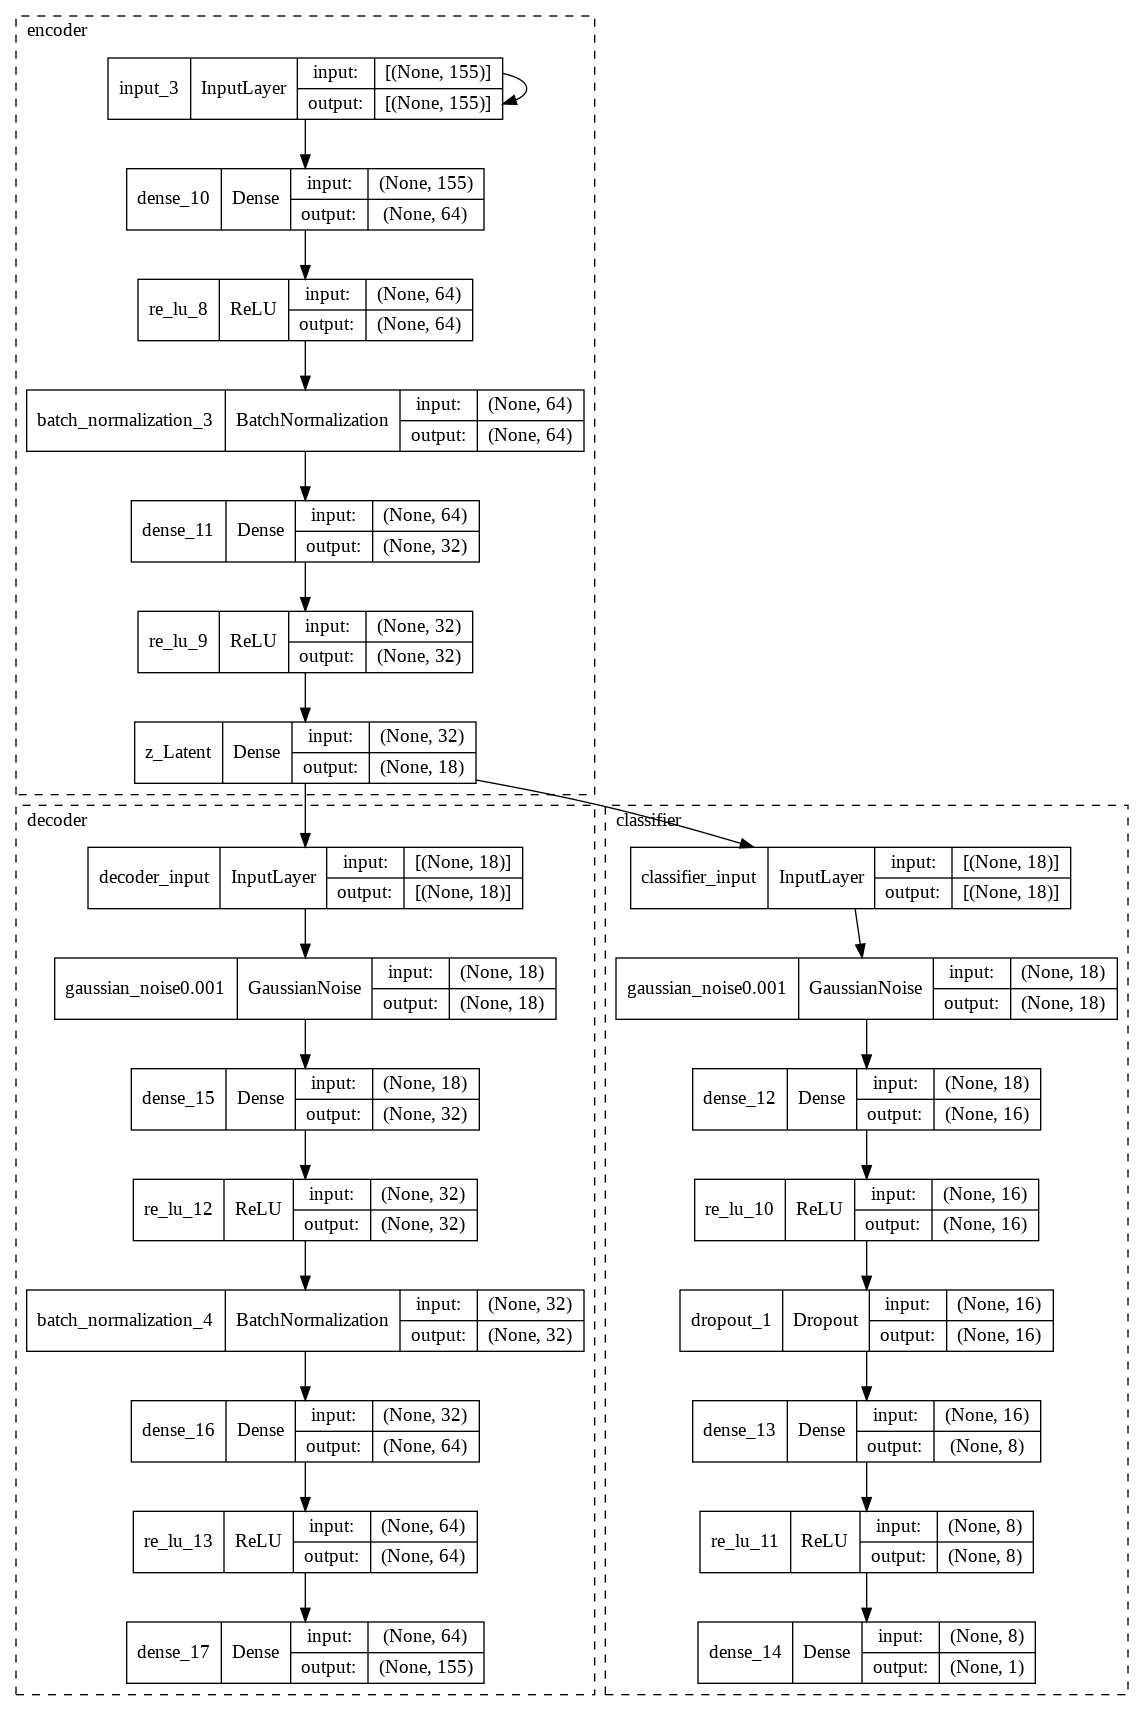

In [ ]:
k,em,dm=get_Auto_Encoder_With_Classifier(X.shape[1],_latentDim,_neuronCountsForClassifier,_neuronCountsForEncoder)
PlotModel(k)        

#Train Models By Model Type

-----------fold: 0 sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20 training----------
Epoch 1/20
2270/2270 [==============================] - 16s 5ms/step - loss: 0.2728 - decoder_loss: 0.2567 - classifier_loss: 0.0162 - classifier_tp: 226.0000 - classifier_fp: 792.0000 - classifier_tn: 225810.0000 - classifier_fn: 152.0000 - classifier_accuracy: 0.9958 - classifier_precision: 0.2220 - classifier_recall: 0.5979 - classifier_auc: 0.9158
Epoch 2/20
2270/2270 [==============================] - 12s 5ms/step - loss: 0.2510 - decoder_loss: 0.2475 - classifier_loss: 0.0034 - classifier_tp: 287.0000 - classifier_fp: 46.0000 - classifier_tn: 226556.0000 - classifier_fn: 91.0000 - classifier_accuracy: 0.9994 - classifier_precision: 0.8619 - classifier_recall: 0.7593 - classifier_auc: 0.9352
Epoch 3/20
2270/2270 [==============================] - 13s 6ms/step - loss: 0.2489 - decoder_loss: 0.2458 - classifier_loss: 0.0032 - classifier_tp: 295.0000 - classifier_fp: 39.0000 - classifi

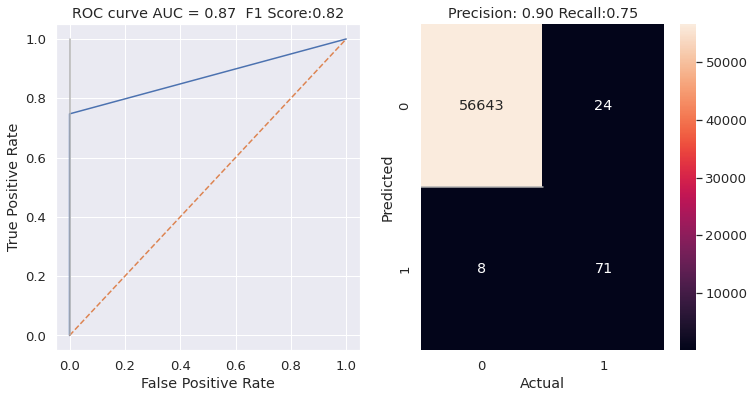

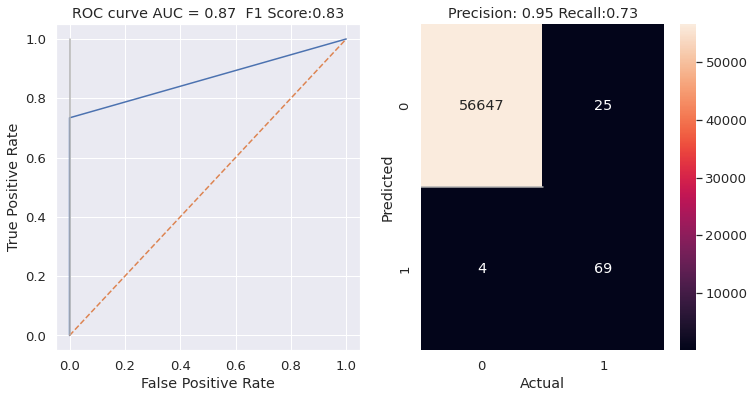

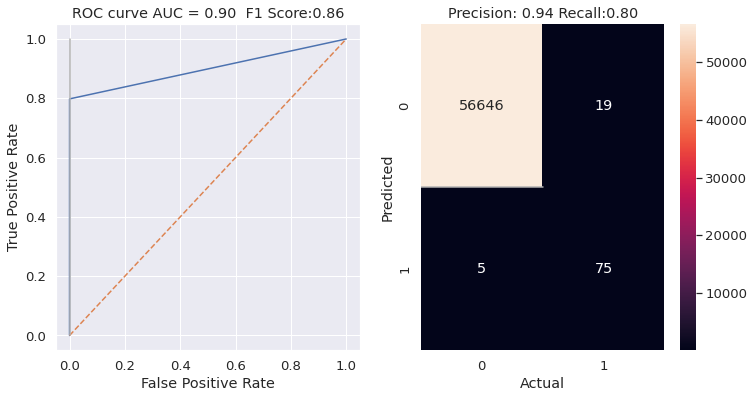

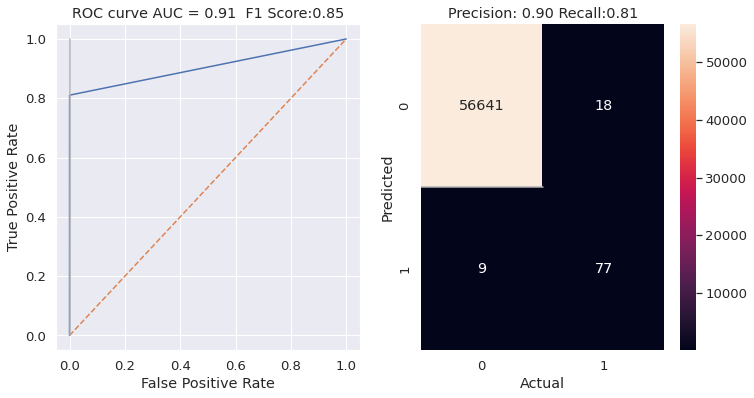

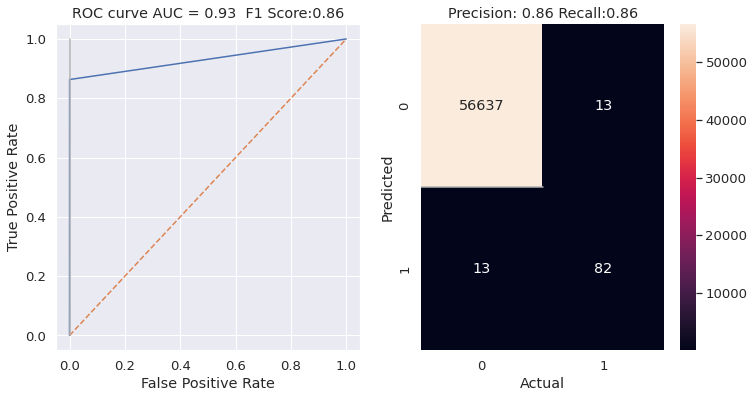

In [ ]:
_kFoldCount=5
_neuronCountsForEncoder=[64,32]
_neuronCountsForClassifier=[16,8]
_batch_size=100
_maxEpochs=20
_trainDataCount=0
_testDataCount=0
_trainDataCountPositives=0
_testDataCountsPositives=0
_verbose=1
_positionalEncoding=True
foldModels={}
currentFold=-1
globalSettings={}
globalSettings['FoldCount']=_kFoldCount
globalSettings['RandomState']=_randomState
globalSettings['Scaling']=_scaling
# globalSettings['Patience']=_patience
globalSettings['BatchSize']=_batch_size
globalSettings['PositionalEncoding']=_positionalEncoding
oversamplingRate=0
modelTypeList=['sae']
_oversamplingMethod='None'

cv = StratifiedKFold(n_splits=_kFoldCount, random_state = _randomState, shuffle=True)
for train_indexes,validation_indexes in cv.split(dataX,dataY):
     currentFold=currentFold+1
    #  if(currentFold!=3):
    #      continue;
     X,Y =dataX[train_indexes],dataY[train_indexes]
     valX,valY = dataX[validation_indexes],dataY[validation_indexes]
     if  (_positionalEncoding): ##Positional encoding should be after scaling 
        X=ApplyPositionalEncoding(X)
        valX=ApplyPositionalEncoding(valX)
     for _latentDim in [18]:
         for modelType in modelTypeList:
                tf.keras.backend.clear_session()#keras backendclear
                np.random.seed(_randomState) #keras backendclear
                tf.random.set_seed(_randomState)#keras backendclear

                nc='_'.join([str(elem) for elem in _neuronCountsForEncoder]) +  '_'.join([str(elem) for elem in _neuronCountsForClassifier]) 
                modelConfigType =modelType+ '_inSize'+ str(X.shape[1]) + '_batchSize_'+ str(_batch_size) + '_PE_' + str(_positionalEncoding) + '_' + nc + '_LD_' + str(_latentDim) + '_epochs_' +str(_maxEpochs)
                print(F"-----------fold: {currentFold} {modelConfigType} training----------")
                modelSavePath=F"{saveToFolder}/{modelConfigType}_gn005_rs_{_randomState}_Fold_{currentFold}"
                m=Mock()
       
                           
                _trainDataCount=X.shape[0]
                _trainDataCountPositives = np.count_nonzero(Y[Y==1])
              
                _validationDataCount=valX.shape[0]
                _validationDataCountPositives = np.count_nonzero(valY[valY==1])
            
                globalSettings['ValidationDataCount']=_validationDataCount
                globalSettings['ValidationDataCountPositives']=_validationDataCountPositives
                globalSettings['TrainDataCount']=_trainDataCount
                globalSettings['TrainDataCountPositives']=_trainDataCountPositives
                globalSettings['OversamplingRate']=oversamplingRate
                
                if (modelType=='bnn'):
                        m.Model=get_bnn(inputShape=X.shape[1],trainSize=X.shape[0],batchSize=_batch_size,neuronCounts=_neuronCountsForClassifier)
                        m.Model._name='BNN' + '_inShape_' +str(X.shape[1]) + '_' +   '_'.join([str(elem) for elem in _neuronCountsForClassifier])
                        m.TrainHistory = m.Model.fit (X,	y={"classifier": Y},
                        #validation_data=(valX,{ "classifier": valY}),
                        epochs=_maxEpochs,
                        verbose=_verbose,
                        batch_size=_batch_size,
                        # callbacks=[earlystopping]
                        )
                        m.TrainHistory=m.TrainHistory.history

                if (modelType=='mlp'):
                        m.Model=get_MLP(X.shape[1],neuronCounts=_neuronCountsForClassifier)
                        m.Model._name='MLP' + '_inShape_' +str(X.shape[1]) + '_' +   '_'.join([str(elem) for elem in _neuronCountsForClassifier])
                        m.TrainHistory = m.Model.fit (X,	y={"classifier": Y},
                        #validation_data=(valX,{ "classifier": valY}),
                        epochs=_maxEpochs,
                        verbose=_verbose,
                        batch_size=_batch_size,
                        # callbacks=[earlystopping]
                        )
                        m.TrainHistory=m.TrainHistory.history

                if (modelType=='sae'):

                      k,em,dm=get_Auto_Encoder_With_Classifier(X.shape[1],_latentDim,_neuronCountsForClassifier,_neuronCountsForEncoder)
                      #m.Model._name='SemiSupervised_AE_' + '_inShape_' + str(X.shape[1])  + '_' +  '_'.join([str(elem) for elem in _neuronCountsForEncoder]) + '_L_'+str(_latentDim) + '_' + '_CLS_' + '_'.join([str(elem) for elem in _neuronCountsForClassifier] ) + '_'
                     
                      history = k.fit (X,	y= [X ,Y ],
                                                      #validation_data=(valX,{"decoder":valX,'classifier':valY}),
                                                      epochs=_maxEpochs,
                                                      verbose=_verbose,
                                                      batch_size=_batch_size)
                      k.save(F"{modelSavePath}/BaseModel",overwrite=True)
                      em.save(F"{modelSavePath}/{em._name}",overwrite=True)
                      dm.save(F"{modelSavePath}/{dm._name}",overwrite=True)
                      m.EncoderModel=em
                      m.DecoderModel=dm
                      m.EncoderModel._name=k._name + '_encoder'
                      m.DecoderModel._name=k._name + '_decoder'
                      m.TrainHistory=history.history
                      m.Model=k
                if (modelType=='vae'):


                      Y=Y.astype(float).reshape(-1,1)
                      k,em,dm=get_Variational_Encoder_WithClassifier(X.shape[1],_latentDim,_neuronCountsForClassifier,_neuronCountsForEncoder)
                      history = k.fit (X,	y= [X ,Y ],
                                                      #validation_data=(valX,{"decoder":valX,'classifier':valY}),
                                                      epochs=_maxEpochs,
                                                      verbose=_verbose,
                                                      batch_size=_batch_size)
                      k.save(F"{modelSavePath}/BaseModel",overwrite=True)
                      em.save(F"{modelSavePath}/{em._name}",overwrite=True)
                      dm.save(F"{modelSavePath}/{dm._name}",overwrite=True)
                      m.EncoderModel=em
                      m.DecoderModel=dm
                      m.EncoderModel._name=k._name + '_encoder'
                      m.DecoderModel._name=k._name + '_decoder'
                      m.TrainHistory=history.history
                      m.Model=k
         
                m.Settings={}
                m.Settings['neuronCountsForClassifier']=nc
                m.Settings['oversamplingRate']=oversamplingRate
                m.Settings['oversamplingMethod']=_oversamplingMethod
                m.Settings['latentDim']=_latentDim


                m.GlobalSettings=globalSettings
                m.ModelType=modelType
                # m.TrainHistory=mlphistory
              

                # scores= m.Model.evaluate(valX, valY, verbose=0,batch_size=_batch_size)
                # m.Name = m.Model._name
                # m.NameFull=modelConfigType
                # m.EvaluationMetrics = pd.DataFrame(np.array([scores]), columns=m.Model.metrics_names)
                # m.EvaluationMetrics.insert(0,"Name",m.Model._name)
                # m.EvaluationMetrics.insert(0,"Fold",currentFold)

                predictions = m.Model.predict(valX)
                predictions = sklearn.preprocessing.binarize(predictions[1],  threshold=0.5, copy=True)
               
                drawROCCurve(valY,predictions,'',savePath=F"{modelSavePath}/confusion.png")
                pickle.dump(scaler, open(F"{modelSavePath}/scaler.sav", 'wb'))

                foldModels[(modelConfigType,currentFold)]=m


Model: "SemiSupervisedAEWithClassifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155)]        0           []                               
                                                                                                  
 encoder (Functional)           (None, 18)           12914       ['input_1[0][0]']                
                                                                                                  
 decoder (Functional)           (None, 155)          12923       ['encoder[0][0]']                
                                                                                                  
 classifier (Functional)        (None, 1)            449         ['encoder[0][0]']                
                                                                     

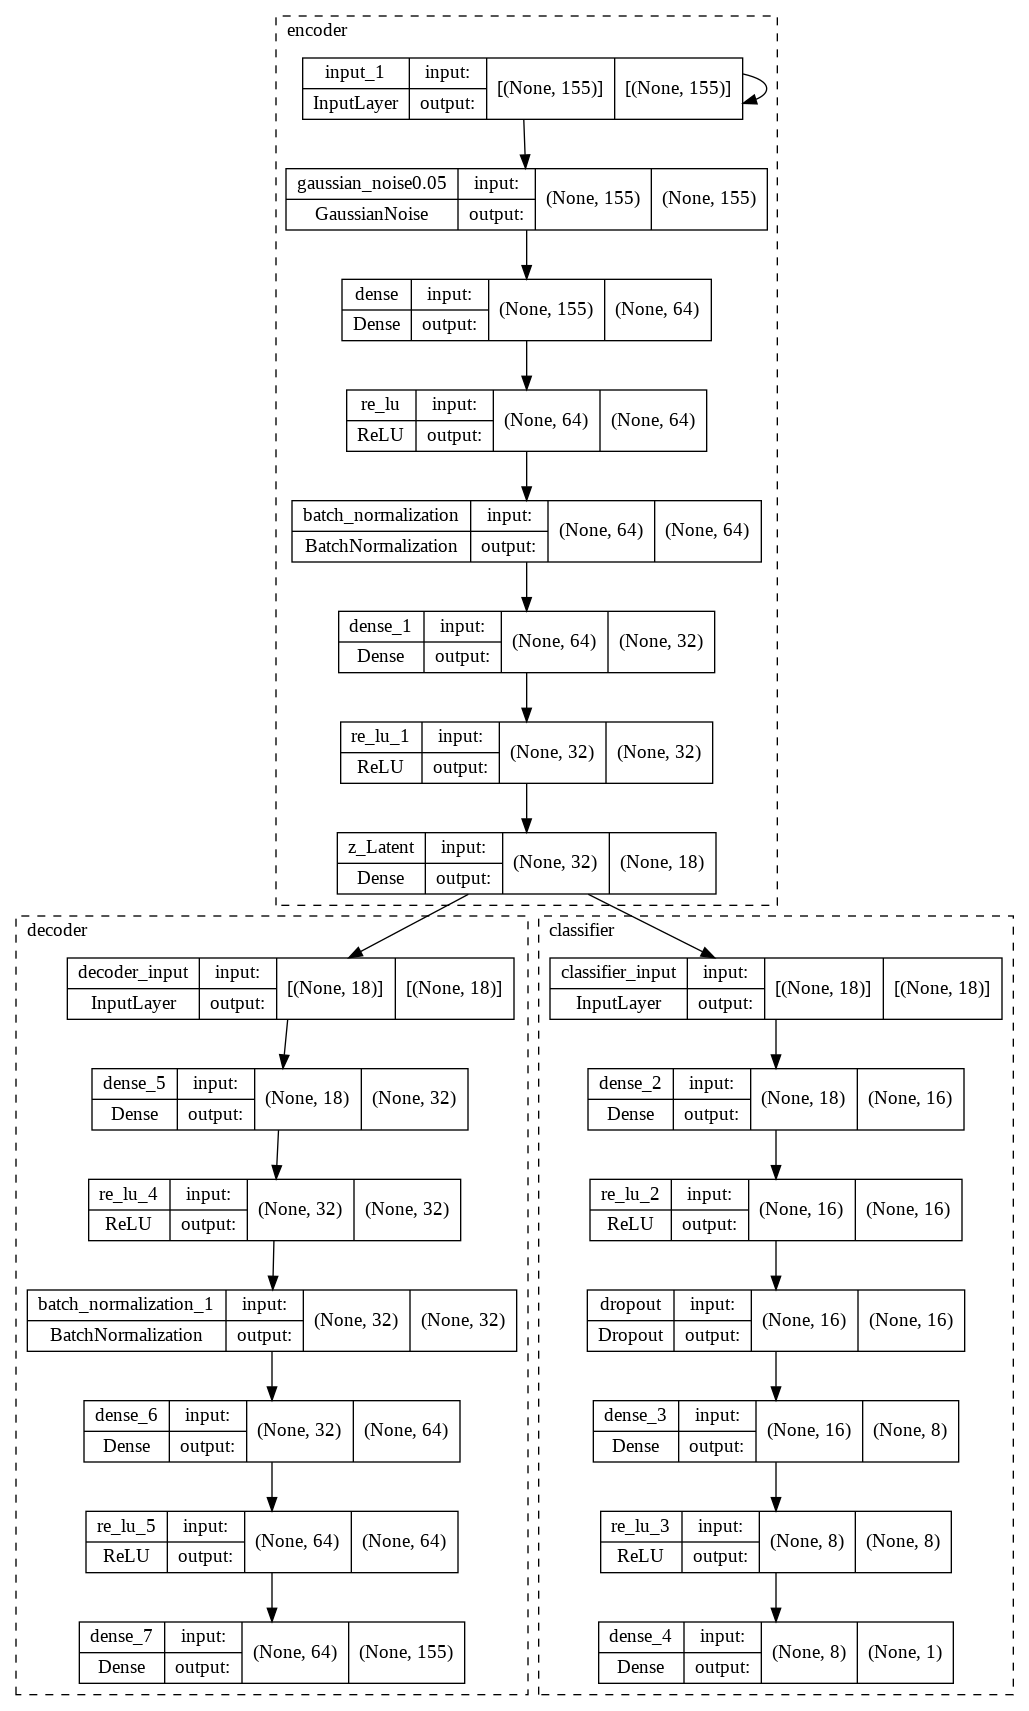

In [ ]:
modelfoldNumber=3
loadName=F"sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_s_16_Fold_{modelfoldNumber}"
k=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/BaseModel')
k.summary()
# trainModelForFold(k,modelfoldNumber,30)
PlotModel(k)


In [ ]:
testModelForFold(k,3,False,True)
# k.summary()
#k.save(F'{saveToFolder}/TheBEST/vae_inSize155_batchSize_200_PE_True_16_8_LD_12_epochs_50_Fold_0')

RandomState: 16
Testing With Fold: 3
╒════╤══════════╤═══════════════╤══════════════════╤═════════════╤══════════╤═══════╕
│    │     Loss │   DecoderLoss │   ClassifierLoss │   Precision │   Recall │    F1 │
╞════╪══════════╪═══════════════╪══════════════════╪═════════════╪══════════╪═══════╡
│  0 │ 0.225658 │      0.222835 │       0.00282216 │       0.897 │    0.888 │ 0.892 │
╘════╧══════════╧═══════════════╧══════════════════╧═════════════╧══════════╧═══════╛
Mean Results
╒════════╤═══════════════╤══════════════════╤═════════════╤══════════╤══════╕
│   Loss │   DecoderLoss │   ClassifierLoss │   Precision │   Recall │   F1 │
╞════════╪═══════════════╪══════════════════╪═════════════╪══════════╪══════╡
│   0.23 │          0.22 │                0 │         0.9 │     0.89 │ 0.89 │
╘════════╧═══════════════╧══════════════════╧═════════════╧══════════╧══════╛
Standart Deviation Results
╒════════╤═══════════════╤══════════════════╤═════════════╤══════════╤══════╕
│   Loss │   DecoderLoss 

,Loss,DecoderLoss,ClassifierLoss,Precision,Recall,F1
0,"0 0.225658 Name: loss, dtype: float64","0 0.222835 Name: decoder_loss, dtype: float64","0 0.002822 Name: classifier_loss, dtype: fl...","0 0.897 Name: classifier_precision, dtype: ...","0 0.888 Name: classifier_recall, dtype: flo...",0 0.892 dtype: float64


In [ ]:
modelfoldNumber=3
loadName=F"sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_rs_16_Fold_{modelfoldNumber}"
k=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/BaseModel')
def pruneModel(modelP,threshold):
  arr=[]
  for innerModel in modelP.layers:
      if (innerModel.name=='encoder' or innerModel.name=='decoder' or innerModel.name=='classifier'):
        layerNumber=0
        for layer in innerModel.layers:
          if (layer.name.startswith('dense')):
            layerNumber=layerNumber+1
            weights=layer.get_weights()[0]
            biases =layer.get_weights()[1]
            mean=np.array(weights).mean();
            std=np.array(weights).std()
            for i in range(weights.shape[0]):
              for j in range(weights.shape[1]):
                if (abs(weights[i][j])<=threshold and weights[i][j]!=0):
                      weights[i][j]=0
                      xName=innerModel.name + '_dense_' +str(layerNumber)
                      arr.append([xName,i,j])
            layer.set_weights([weights,biases])
  print(len(arr)," weights prunned", "with threshold:", threshold)
resultList=[]
threshold=0.01
while threshold<0.20:
  pruneModel(k,threshold)
# trainModelForFold(k,modelfoldNumber,10)
  r=testModelForFold(k,modelfoldNumber,False,False)
  resultList.append(r['F1'].item()[0])
  print(threshold)
  print(r['F1'].item()[0])
  threshold=threshold+0.02
print(resultList)

2973  weights prunned with threshold: 0.01
RandomState: 16
Testing With Fold: 3
0.01
0.86
3360  weights prunned with threshold: 0.03
RandomState: 16
Testing With Fold: 3
0.03
0.865
2646  weights prunned with threshold: 0.05
RandomState: 16
Testing With Fold: 3
0.05
0.86
2245  weights prunned with threshold: 0.07
RandomState: 16
Testing With Fold: 3
0.07
0.86
2032  weights prunned with threshold: 0.09000000000000001
RandomState: 16
Testing With Fold: 3
0.09000000000000001
0.866
1836  weights prunned with threshold: 0.11000000000000001
RandomState: 16
Testing With Fold: 3
0.11000000000000001
0.86
1598  weights prunned with threshold: 0.13
RandomState: 16
Testing With Fold: 3
0.13
0.838
1315  weights prunned with threshold: 0.15
RandomState: 16
Testing With Fold: 3
0.15
0.837
1180  weights prunned with threshold: 0.16999999999999998
RandomState: 16
Testing With Fold: 3
0.16999999999999998
0.825
1082  weights prunned with threshold: 0.18999999999999997
RandomState: 16
Testing With Fold: 3


KeyboardInterrupt: ignored

In [ ]:
print(resultList)

[0.882, 0.882, 0.888, 0.888, 0.883, 0.888, 0.894, 0.894, 0.892, 0.897, 0.892, 0.894, 0.899, 0.915, 0.888, 0.892, 0.892, 0.747, 0.886]


In [ ]:
trainModelForFold(k,modelfoldNumber,epoch=1,_batch_size=100)


Training With Fold: 3
2279/2279 [==============================] - 13s 5ms/step - loss: 0.2458 - decoder_loss: 0.2434 - classifier_loss: 0.0024 - classifier_tp: 308.0000 - classifier_fp: 18.0000 - classifier_tn: 227434.0000 - classifier_fn: 86.0000 - classifier_accuracy: 0.9995 - classifier_precision: 0.9448 - classifier_recall: 0.7817 - classifier_auc: 0.9509


{'classifier_accuracy': [0.9995435476303101],
 'classifier_auc': [0.9509067535400391],
 'classifier_fn': [86.0],
 'classifier_fp': [18.0],
 'classifier_loss': [0.0024423126596957445],
 'classifier_precision': [0.9447852969169617],
 'classifier_recall': [0.7817258834838867],
 'classifier_tn': [227434.0],
 'classifier_tp': [308.0],
 'decoder_loss': [0.24335947632789612],
 'loss': [0.24580176174640656]}

Testing With Fold: 3

Mean Results

Standart Deviation Results



""


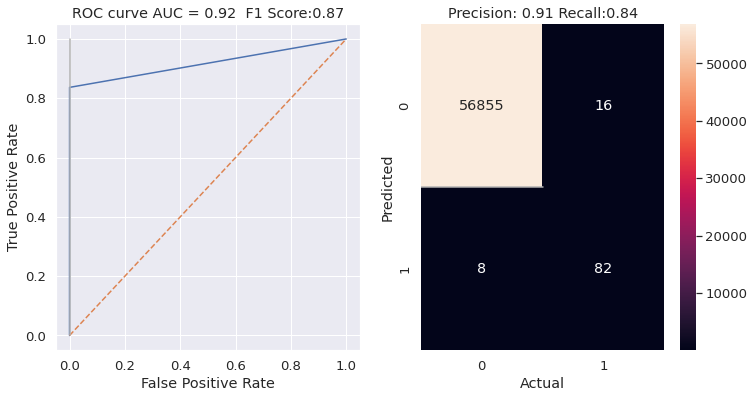

In [ ]:
testModelForFold(k,modelfoldNumber,True,True)

In [ ]:
tf.keras.backend.clear_session()
innerLoadName="BaseModel"
dfResults=pd.DataFrame()
name="sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_15_gn005_3rd_Fold_0"
initalEpoch=15
plusEpochs=5

epochList=[]
resultList=[]


for foldNumber in [0,1,2,3,4]:
    loadName=F"{name}_Fold_{foldNumber}"
    mx=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{innerLoadName}')
    foldResults=[]
    currentEpoch=initalEpoch
    epochList.append(currentEpoch)

    while (currentEpoch<50):
      print('Fold:',foldNumber, 'Epoch:',currentEpoch)
      currentEpoch=currentEpoch+plusEpochs
      trainModelForFold(mx,foldNumber,plusEpochs)
      results=testModelForFold(mx,foldNumber,False,False)
      foldResults.append(results['F1'].item()[0])
    resultList.append(foldResults)



KeyboardInterrupt: ignored

In [ ]:
print(resultList)

print(np.mean(resultList,axis=0))
print(epochList)

In [ ]:
predictions = k.predict(valX)
predictions = sklearn.preprocessing.binarize(predictions[1],  threshold=0.5, copy=True)
               
drawROCCurve(valY,predictions,'',savePath=F"{modelSavePath}/confusion.png")

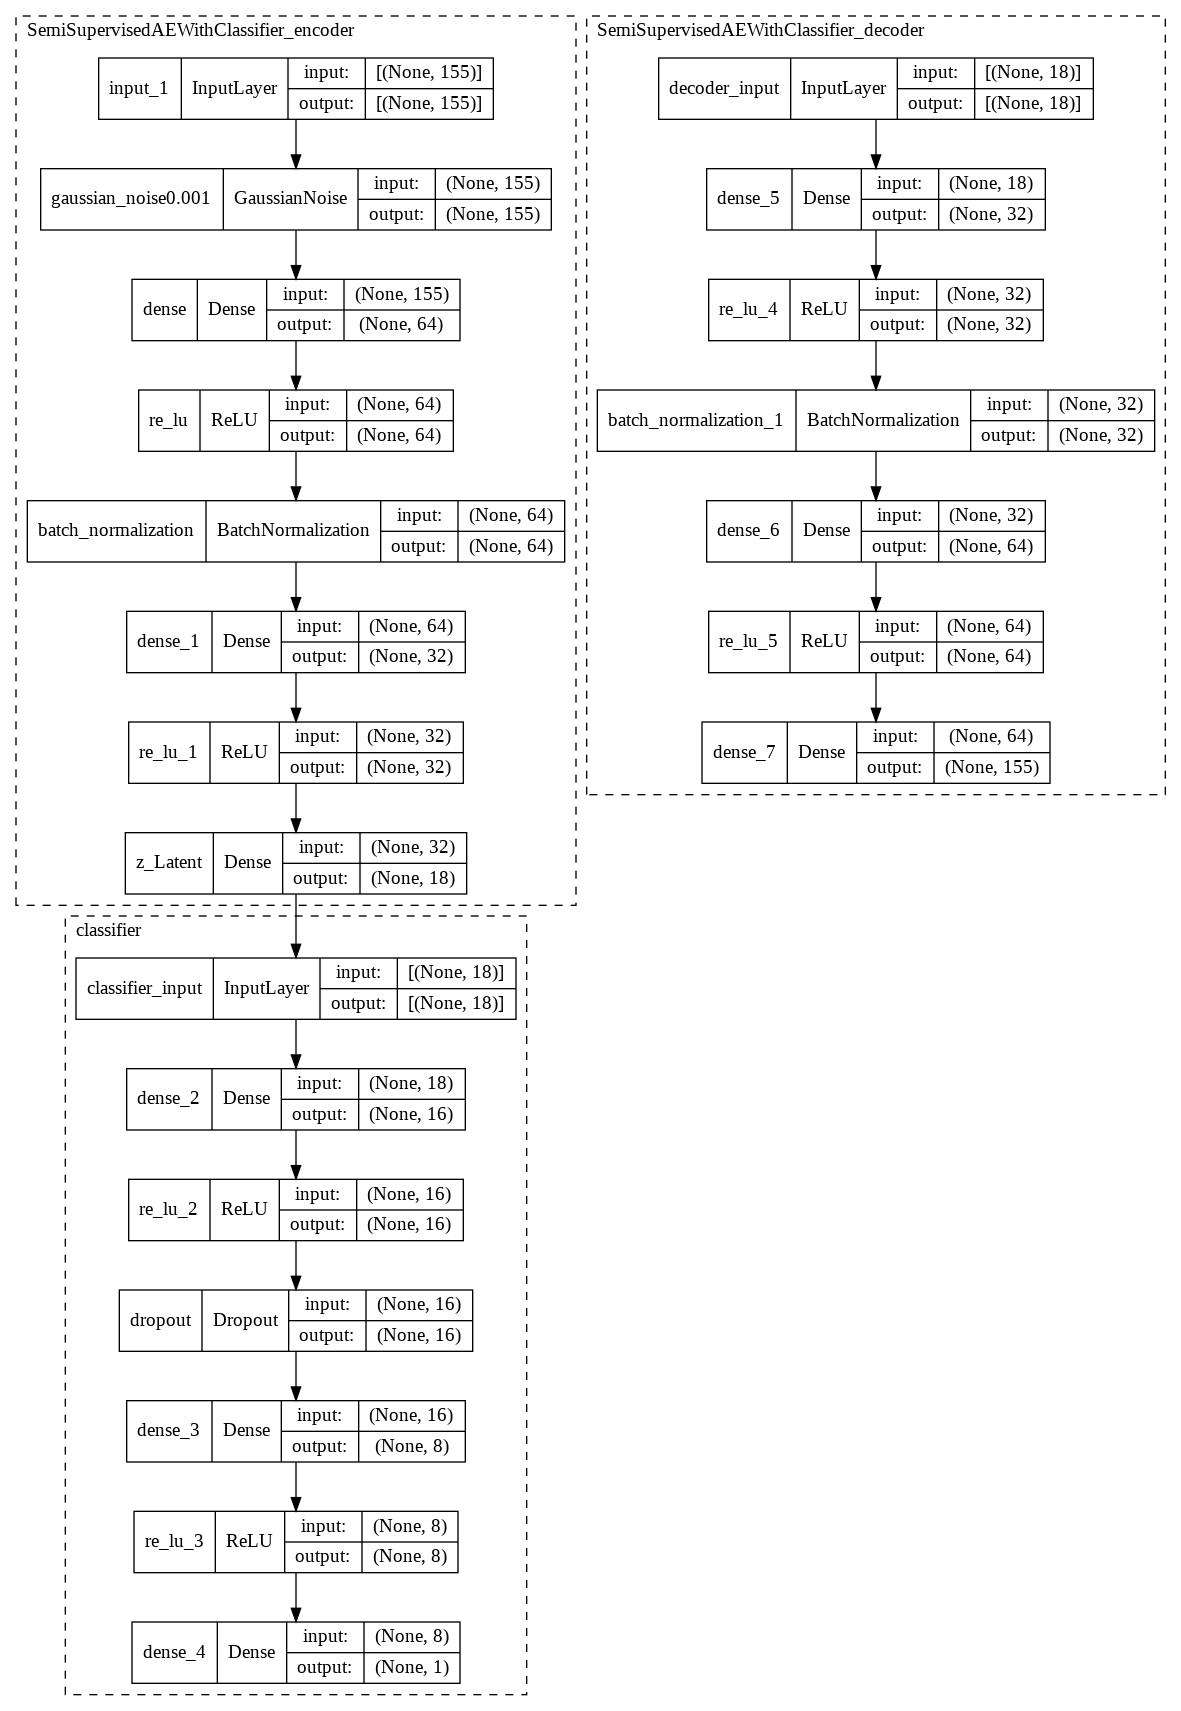

In [ ]:
PlotModel(k)

In [ ]:
import statistics
from math import sqrt
from functools import reduce

def stddev(lst):
    mean = float(sum(lst)) / len(lst)
    return sqrt(float(reduce(lambda x, y: x + y, map(lambda x: (x - mean) ** 2, lst))) / len(lst))
def getRMean(list,pDecimal):
  return np.round(np.mean(list),pDecimal)
distinctKeys=[]
for i,j in foldModels:
 if not i in distinctKeys:
   print(i)
   distinctKeys.append(i)
   

print(tabulate((pd.DataFrame.from_dict(foldModels[(distinctKeys[0],0)].GlobalSettings, orient='index').T),headers='keys', tablefmt='fancy_grid'))

dfResults=pd.DataFrame()
for i in distinctKeys:
  f1List=[]
  precisionList=[]
  recallList=[]
  lossList=[]
  for j in range(0,currentFold):
        m=foldModels[(i,j)]
        if (m.ModelType=='mlp'):
            precision=m.EvaluationMetrics['precision']
            recall=m.EvaluationMetrics['recall']
        else:
            precision=m.EvaluationMetrics['classifier_precision']
            recall=m.EvaluationMetrics['classifier_recall']
        loss=m.EvaluationMetrics['loss']
        f1 = 2*precision*recall/(precision+recall+K.epsilon())
        m.EvaluationMetrics["F1"]=np.round(f1,2)
        f1List.append(f1)
        precisionList.append(precision)
        recallList.append(recall)
        lossList.append(loss)
        epochCount=len(m.TrainHistory['loss'])
        print(tabulate(m.EvaluationMetrics,headers='keys', tablefmt='fancy_grid'))


  stdevF1 = stddev(f1List)
  data=[foldModels[(i,0)].Model._name,m.Model.count_params(),epochCount,getRMean(lossList,2), getRMean(precisionList,2),getRMean(recallList,2),getRMean(f1List,2),np.round(stdevF1,2)]
  columns=['Model','ParamCount','EpochCount','M-Loss','M-Precision','M-Recall','M-F1','std-F1']
  rEvaluation=pd.DataFrame([data],index=None,columns=columns)
  dfResults=pd.concat([dfResults,rEvaluation], axis=0,ignore_index=True)
dfResults=dfResults.sort_values(by=['M-F1'], ascending=False,ignore_index=True)

print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))
# PlotModel(foldModels[(i,j)].Model)


sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20
╒════╤═════════════╤═══════════════╤═══════════╤═════════════╤══════════════════════╤═══════════════════════╤════════════════════════════════╤══════════════════╤═══════════════════════════╤════════════════════╕
│    │   FoldCount │   RandomState │ Scaling   │   BatchSize │ PositionalEncoding   │   ValidationDataCount │   ValidationDataCountPositives │   TrainDataCount │   TrainDataCountPositives │   OversamplingRate │
╞════╪═════════════╪═══════════════╪═══════════╪═════════════╪══════════════════════╪═══════════════════════╪════════════════════════════════╪══════════════════╪═══════════════════════════╪════════════════════╡
│  0 │           5 │            16 │ MinMax    │         100 │ True                 │                 56961 │                             98 │           227846 │                       394 │                  0 │
╘════╧═════════════╧═══════════════╧═══════════╧═════════════╧══════════════════════╧═════════

# Plot Model Layers

In [ ]:
for modelLayer in m.Model.layers:
  if(modelLayer.name=='encoder'):
    x=(modelLayer)
    PlotModel(x)

#Prunnig

In [ ]:
def pruneCondition(mean,std,weight,threshold):
   if ( abs(weight) < threshold):
     return True;
  # if (weight > mean+2*std or weight<mean-2*std):
  #   return True;
    
def pruneModelWithGiven(modelP,weightsGiven):
  arr=[]
  for innerModel in modelP.layers:
      if (innerModel.name=='encoder' or innerModel.name=='decoder' or innerModel.name=='classifier'):
        layerNumber=0
        for layer in innerModel.layers:
          if (layer.name.startswith('dense')):
            layerNumber=layerNumber+1
            weights=layer.get_weights()[0]
            biases =layer.get_weights()[1]
            for i in range(weights.shape[0]):
              for j in range(weights.shape[1]):
                if (weights[i][j]!=0):
                 xName=innerModel.name + '_dense_' +str(layerNumber)
                 if [xName,i,j] in weightsGiven:
                      weights[i][j]=0
                      arr.append([xName,i,j])
            layer.set_weights([weights,biases])
  print(len(arr)," weights prunned")
  return arr,modelP

def pruneModel(modelP,prunningNumber):
  arr=[]
  for innerModel in modelP.layers:
      if (innerModel.name=='encoder' or innerModel.name=='decoder' or innerModel.name=='classifier'):
        layerNumber=0
        for layer in innerModel.layers:
          if (layer.name.startswith('dense')):
            layerNumber=layerNumber+1
            weights=layer.get_weights()[0]
            biases =layer.get_weights()[1]
            mean=np.array(weights).mean();
            std=np.array(weights).std()
            for i in range(weights.shape[0]):
              for j in range(weights.shape[1]):
                if (weights[i][j]!=0):
                  if pruneCondition(mean,std,weights[i][j]):
                      weights[i][j]=0
                      xName=innerModel.name + '_dense_' +str(layerNumber)
                      arr.append([xName,i,j])
            layer.set_weights([weights,biases])
  print(len(arr)," weights prunned")
  return arr,modelP

In [ ]:
from pyparsing.core import MatchFirst

modelfoldNumber=3
retrainEpochs=5

loadName=F"sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_s_16_Fold_{modelfoldNumber}"

mFirst=None
mSecond=None
mThird=None
mIntersecion=None
mUnion=None

arr1=[]
arr2=[]
arr3=[]

reTrainAndSave=False



 

  


originalModelName="BaseModel"
firstPrunningModelName="FirstPrunning"
firstPrunningBeforeTraining="FirstPrunningBeforeTraining"

secondPrunningModelName="SecondPrunning"
secondPrunningBeforeTraining="SecondPrunningBeforeTraining"

thirdPrunningModelName="ThirdPrunning"
thirdPrunningBeforeTraining="ThirdPrunningBeforeTraining"


mOriginal=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{originalModelName}')
for prunningNumber in [1,2,3]:
   if(prunningNumber==1):
        mOriginal=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{originalModelName}')
        arr1,mFirst=pruneModel(mOriginal,prunningNumber)
        mFirst.save(F'{saveToFolder}/{loadName}/{firstPrunningBeforeTraining}')
   if(prunningNumber==2):
        mFirst=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{firstPrunningModelName}')
        arr2,mSecond=pruneModel(mFirst,prunningNumber)
        mSecond.save(F'{saveToFolder}/{loadName}/{secondPrunningBeforeTraining}')

   if(prunningNumber==3):
        mSecond=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{secondPrunningModelName}')
        arr3,mThird=pruneModel(mSecond,prunningNumber)
        mThird.save(F'{saveToFolder}/{loadName}/{thirdPrunningBeforeTraining}')

   if (reTrainAndSave):
     if(prunningNumber==1):
       trainModelForFold(mFirst,modelfoldNumber,epoch=retrainEpochs)
       mFirst.save(F'{saveToFolder}/{loadName}/{firstPrunningModelName}')
     if(prunningNumber==2):
       trainModelForFold(mSecond,modelfoldNumber,epoch=retrainEpochs)
       mSecond.save(F'{saveToFolder}/{loadName}/{secondPrunningModelName}')
     if(prunningNumber==3):
       trainModelForFold(mThird,modelfoldNumber,epoch=retrainEpochs)
       mThird.save(F'{saveToFolder}/{loadName}/{thirdPrunningModelName}')


10180  weights prunned
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CreditCardFraudDetection/Models//sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_rs_16_Fold_2/FirstPrunningBeforeTraining/assets
Training With Fold: 2
Epoch 1/5
1140/1140 [==============================] - 12s 8ms/step - loss: 0.2446 - decoder_loss: 0.2425 - classifier_loss: 0.0021 - classifier_tp: 324.0000 - classifier_fp: 21.0000 - classifier_tn: 227431.0000 - classifier_fn: 70.0000 - classifier_accuracy: 0.9996 - classifier_precision: 0.9391 - classifier_recall: 0.8223 - classifier_auc: 0.9614
Epoch 2/5
1140/1140 [==============================] - 8s 7ms/step - loss: 0.2445 - decoder_loss: 0.2424 - classifier_loss: 0.0020 - classifier_tp: 320.0000 - classifier_fp: 20.0000 - classifier_tn: 227432.0000 - classifier_fn: 74.0000 - classifier_accuracy: 0.9996 - classifier_precision: 0.9412 - classifier_recall: 0.8122 - classifier_auc: 0.9602
Epoch 3/5
1140/1140 [==========================

In [ ]:
reTrainAndSave=True
intersectionWeights=[x for x in arr1 if x in arr2 and x in arr3]

intersectionPrunningModelName="IntersectionPrunning"
intersectionPrunningModelNameBeforeTraining="IntersectionPrunningBeforeTraining"


mOriginal1=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{originalModelName}')
arrIntersection, mIntersection=pruneModelWithGiven(mOriginal1,intersectionWeights)
mIntersection.save(F'{saveToFolder}/{loadName}/{intersectionPrunningModelNameBeforeTraining}')
if (reTrainAndSave):
    trainModelForFold(mIntersection,modelfoldNumber,epoch=retrainEpochs)
    mIntersection.save(F'{saveToFolder}/{loadName}/{intersectionPrunningModelName}')

6651  weights prunned
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CreditCardFraudDetection/Models//sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_rs_16_Fold_2/IntersectionPrunningBeforeTraining/assets
Training With Fold: 2
Epoch 1/5
1140/1140 [==============================] - 12s 8ms/step - loss: 0.2446 - decoder_loss: 0.2425 - classifier_loss: 0.0021 - classifier_tp: 326.0000 - classifier_fp: 18.0000 - classifier_tn: 227434.0000 - classifier_fn: 68.0000 - classifier_accuracy: 0.9996 - classifier_precision: 0.9477 - classifier_recall: 0.8274 - classifier_auc: 0.9614
Epoch 2/5
1140/1140 [==============================] - 10s 9ms/step - loss: 0.2445 - decoder_loss: 0.2424 - classifier_loss: 0.0020 - classifier_tp: 317.0000 - classifier_fp: 22.0000 - classifier_tn: 227430.0000 - classifier_fn: 77.0000 - classifier_accuracy: 0.9996 - classifier_precision: 0.9351 - classifier_recall: 0.8046 - classifier_auc: 0.9614
Epoch 3/5
1140/1140 [===================

#Test Prunned Models With Own Folds

In [ ]:
tf.keras.backend.clear_session()
loadFrom='/content/drive/MyDrive/CreditCardFraudDetection/Models/TheBEST/'

modelfoldNumber=3
loadName=F"sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_s_16_Fold_{modelfoldNumber}"

originalModelName="BaseModel"
firstPrunningModelName="FirstPrunning"
firstPrunningBeforeTraining="FirstPrunningBeforeTraining"

secondPrunningModelName="SecondPrunning"
secondPrunningBeforeTraining="SecondPrunningBeforeTraining"

thirdPrunningModelName="ThirdPrunning"
thirdPrunningBeforeTraining="ThirdPrunningBeforeTraining"

intersectionPrunningModelName="IntersectionPrunning"
intersectionPrunningModelNameBeforeTraining="IntersectionPrunningBeforeTraining"




dfResults=pd.DataFrame()
for innerLoadName in [originalModelName,firstPrunningBeforeTraining,firstPrunningModelName,secondPrunningBeforeTraining,secondPrunningModelName,
                     thirdPrunningBeforeTraining,thirdPrunningModelName,intersectionPrunningModelNameBeforeTraining,intersectionPrunningModelName]:
  mx1=tf.keras.models.load_model(F'{loadFrom}/{loadName}/{innerLoadName}')
  resultsSummary=testModelForFold(mx1,modelfoldNumber,False,False)
  newName=loadName + '_' + innerLoadName
  resultsSummary.insert(0,'ModelName',[newName])
  dfResults=pd.concat([dfResults,resultsSummary], axis=0,ignore_index=True, sort=False)

print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))



RandomState: 16
Testing With Fold: 3
RandomState: 16
Testing With Fold: 3
RandomState: 16
Testing With Fold: 3
RandomState: 16
Testing With Fold: 3
RandomState: 16
Testing With Fold: 3
RandomState: 16
Testing With Fold: 3
RandomState: 16
Testing With Fold: 3
RandomState: 16
Testing With Fold: 3
RandomState: 16
Testing With Fold: 3
╒════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════════╤══════════════════╤═════════════╤══════════╤═══════╕
│    │ ModelName                                                                                                                        │     Loss │   DecoderLoss │   ClassifierLoss │   Precision │   Recall │    F1 │
╞════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════╪═══════════════╪══════════════════╪═════════════╪══════════╪═══════╡
│  0 │ sae_inSiz

In [ ]:
cols = ['Loss','DecoderLoss','ClassifierLoss','Precision','Recall','F1']

data_mean = pd.DataFrame([dfResults.mean()], columns=dfResults.columns)
print(tabulate(data_mean, headers='keys', tablefmt='fancy_grid'))


╒════╤═════════════╤══════════╤═══════════════╤══════════════════╤═════════════╤══════════╤══════╕
│    │   ModelName │     Loss │   DecoderLoss │   ClassifierLoss │   Precision │   Recall │   F1 │
╞════╪═════════════╪══════════╪═══════════════╪══════════════════╪═════════════╪══════════╪══════╡
│  0 │         nan │ 0.224736 │      0.220491 │       0.00424444 │    0.921054 │ 0.806316 │ 0.86 │
╘════╧═════════════╧══════════╧═══════════════╧══════════════════╧═════════════╧══════════╧══════╛


In [ ]:
loadFrom='/content/drive/MyDrive/CreditCardFraudDetection/Models/TheBEST/'

modelfoldNumber=3
loadName=F"sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_s_16_Fold_{modelfoldNumber}"
mx1=tf.keras.models.load_model(F'{loadFrom}/{loadName}/FirstPrunning')
print(mx1.layers[1].get_weights()[0])

[[ 0.12182331    0.           -0.14621119   -0.44390473    0.47952625    0.80650043    0.           -0.07213022   -0.15938482   -0.1885425     0.008104682   0.261269      0.037027184  -0.017682215
   0.64661497    0.092391595   0.08065757   -0.22147693    0.30102134   -0.053962007  -0.20355815    0.18012159   -0.35731244    0.26850486    0.270005     -0.14657348    0.           -0.21703863
   0.0026757545 -0.058058657   0.            0.            0.19132814   -0.23499413    0.            0.4992022     0.60275406   -0.24120942    0.47854254    0.090132706  -0.022687403   0.001019314
   0.           -0.28175116   -0.6464717     0.            0.12732409   -0.15018003    0.008600329   0.69767165   -0.5272984     0.29613274    0.           -0.04427263   -0.17448716   -1.1884247
   0.26467022    0.009058811  -0.0066525266  0.            0.           -0.01678802    0.10088898   -0.18601811  ]
 [ 0.888401     -0.14263548    0.            0.06714364    0.03290332   -0.28628248   -0.17373064   

#Test All Fold Trainings

In [ ]:
tf.keras.backend.clear_session()
innerLoadName="BaseModel"
dfResults=pd.DataFrame()
name="sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_s_16"
for foldNumber in [0,1,2,3,4]:
  loadName=F"{name}_Fold_{foldNumber}"
  mx=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{innerLoadName}')
  results=testModelForFold(mx,foldNumber,False,False)
  results.insert(0,'ModelName',[loadName])
  dfResults=pd.concat([dfResults,results], axis=0,ignore_index=True, sort=False)

print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))

cols = ['Loss','DecoderLoss','ClassifierLoss','Precision','Recall','F1']
data_mean = pd.DataFrame([dfResults.mean()], columns=dfResults.columns)
data_mean["ModelName"]=name
print(tabulate(data_mean, headers='keys', tablefmt='fancy_grid'))


Testing With Fold: 0
Testing With Fold: 1
Testing With Fold: 2
Testing With Fold: 3
Testing With Fold: 4
╒════╤═════════════════════════════════════════════════════════════════════════════════════════════╤══════════╤═══════════════╤══════════════════╤═════════════╤══════════╤═══════╕
│    │ ModelName                                                                                   │     Loss │   DecoderLoss │   ClassifierLoss │   Precision │   Recall │    F1 │
╞════╪═════════════════════════════════════════════════════════════════════════════════════════════╪══════════╪═══════════════╪══════════════════╪═════════════╪══════════╪═══════╡
│  0 │ sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_15_gn005_duplicated_rs_16_Fold_0 │ 0.222946 │      0.219262 │       0.0036842  │       0.927 │    0.768 │ 0.84  │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────┼──────────┼───────────────┼──────────────────┼─────────────┼──────────┼────

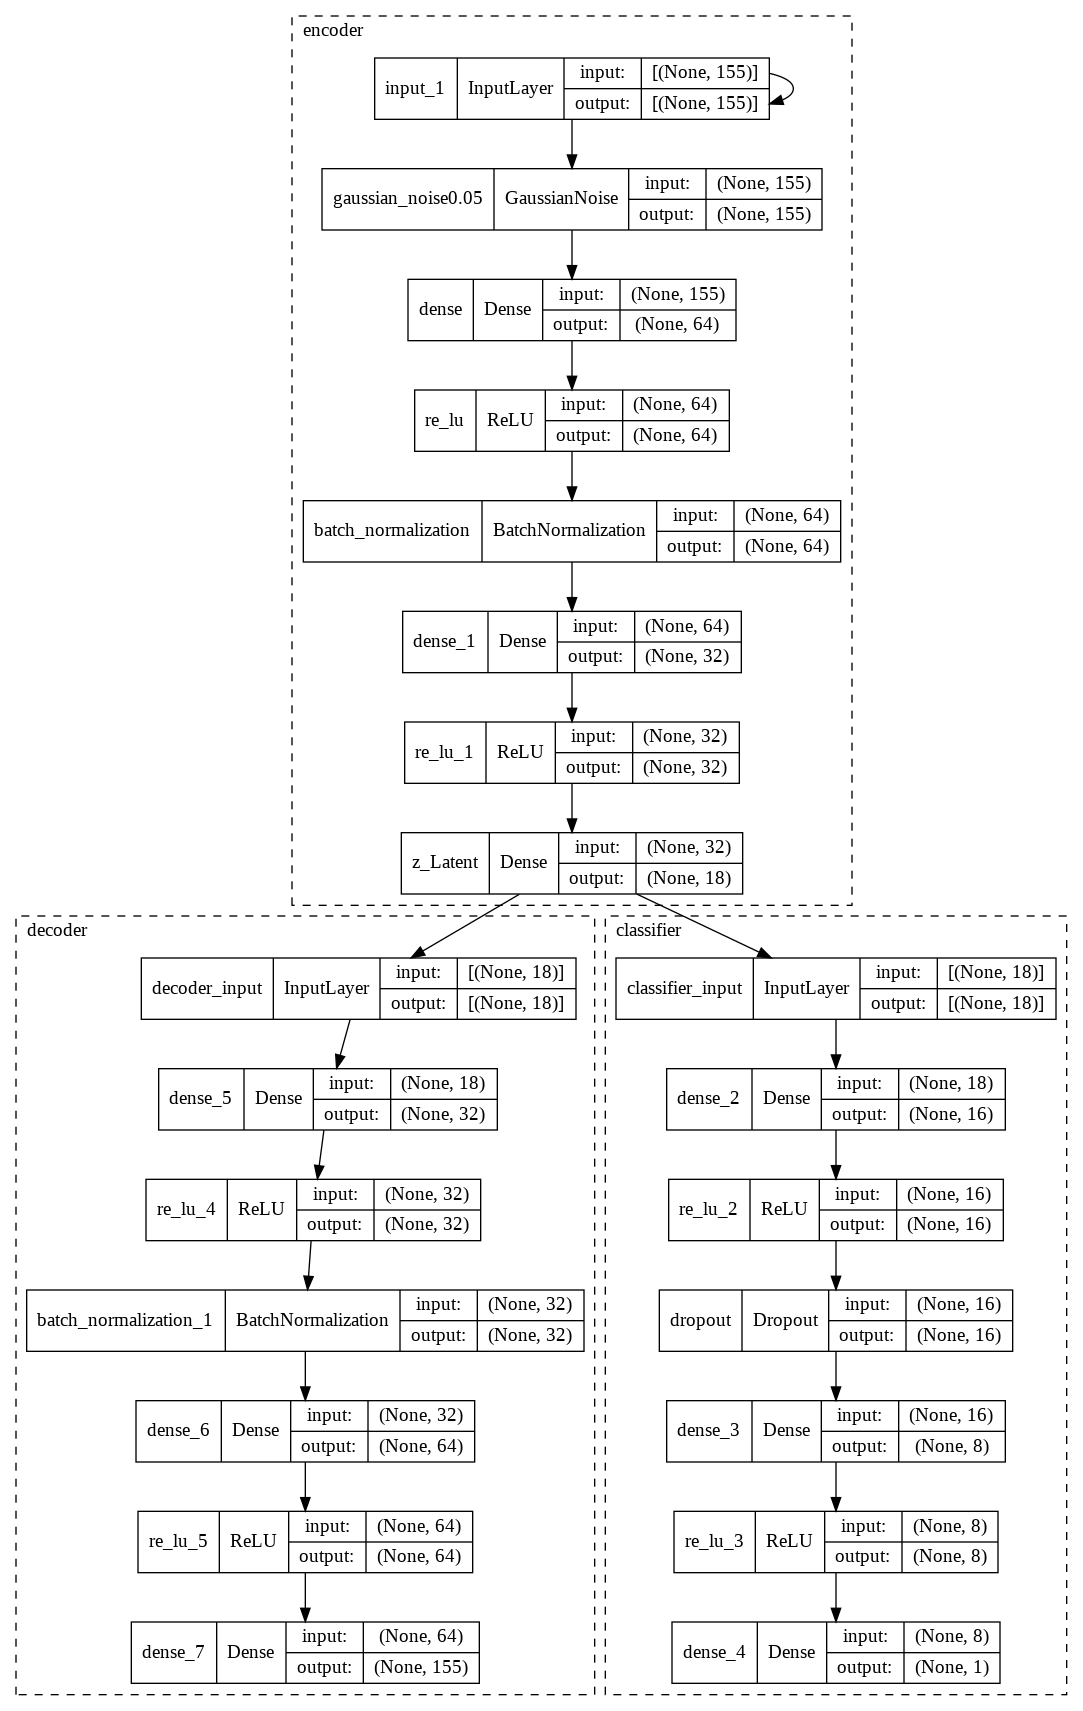

In [ ]:
PlotModel(mx)

#Histogram Of Weights

In [ ]:
m1=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{secondPrunningModelName}')
PlotModel(m1)

In [ ]:

fig,axes=plt.subplots(1, 10, sharex=False, figsize=(80,20))
layerNumber=0


for modelLayer in m1.layers:
      if (modelLayer.name=='encoder' or modelLayer.name=='decoder' or modelLayer.name=='classifier'):
        for layer in modelLayer.layers:
          if ( modelLayer.name=='classifier' and layer.name.startswith('dense_2')):
            weights=layer.get_weights()[0]
            plotTitle=modelLayer.name,layer.name,len(weights)
            for n in range(weights.shape[0]):
                layerNumber=layerNumber+1
                ax1=axes[layerNumber-1]
                y=sns.histplot(weights[n],ax=ax1,bins=50).set(xlabel=n)



In [ ]:
import copy

def pruneConditionX(mean,std,weight,threshold):
  
  if (abs(weight) < threshold and weight!=0):
    return True;

def pruneModel(modelP,threshold):
  _model=copy.deepcopy(modelP)
  weightsP=[]
  for innerModel in _model.layers:
      if (innerModel.name=='encoder' or innerModel.name=='decoder' or innerModel.name=='classifier'):
        for layer in innerModel.layers:
          if (layer.name.startswith('dense')):
            weights=layer.get_weights()[0]
            biases =layer.get_weights()[1]
            mean=np.array(weights).mean() 
            std=np.array(weights).std()
            for i in range(weights.shape[0]):
              for j in range(weights.shape[1]):
                  if pruneConditionX(mean,std,weights[i][j],threshold):
                    weightsP.append(weights[i][j])
                    weights[i][j]=0
            layer.set_weights([weights,biases])

  return weightsP,_model

modelfoldNumber=3
loadName=F"sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_s_16_Fold_{modelfoldNumber}"
modelX=tf.keras.models.load_model(F'{saveToFolder}/TheBEST/{loadName}/BaseModel/')
resultsTest=testModelForFold(modelX,modelfoldNumber,False,False)
resultsTrain=testModelForTrainingFolds(modelX,modelfoldNumber)

improvement=1
threshold=0.00
oldScore=0
prunningArrayTest=[]
prunningArrayTrain=[]

thresholdArray=[]
prunnedWeightCount=[]
thresholdArray.append(0)
prunnedWeightCount.append(0)
prunningArrayTest.append(resultsTest)
prunningArrayTrain.append(resultsTrain)
iter=0
maxIter=20
while (iter<maxIter):
  threshold=threshold+0.01
  iter=iter+1
  thresholdArray.append(threshold)
  xp1,prunnedModel=pruneModel(modelX,threshold)
  resultsTest=testModelForFold(prunnedModel,modelfoldNumber,False,False)
  resultsTrain=testModelForTrainingFolds(prunnedModel,modelfoldNumber)
  prunningArrayTest.append(resultsTest)
  prunningArrayTrain.append(resultsTrain)

  prunnedWeightCount.append(len(xp1))
  #history=trainModelForFold(prunnedModel,modelfoldNumber,epoch=1)
  # startAuc=history['classifier_auc'][0]
  # while (history['classifier_auc'][0]>=startAuc):
  #   startAuc=history['classifier_auc'][0]
  #   history=trainModelForFold(prunnedModel,modelfoldNumber,epoch=1)
  #results=testModelForFold(prunnedModel,modelfoldNumber,False,False)
  #resultsRetraining.append(results['F1'].item()[0])
  #if (history['classifier_auc'][0]<oldScore):
    #improvement=0
  # else:
  #   print(tabulate(results, headers='keys', tablefmt='fancy_grid'))
  #oldScore=history['classifier_auc'][0]


RandomState: 16
Testing With Fold: 3
RandomState: 16
Data shape: (227846, 31)
INFO:tensorflow:Assets written to: ram://adb8fe04-6b39-49f6-a604-0f2ada2aa197/assets
RandomState: 16
Testing With Fold: 3
RandomState: 16
Data shape: (227846, 31)
INFO:tensorflow:Assets written to: ram://162fc3a1-672c-4f13-9a66-69a898676ecc/assets
RandomState: 16
Testing With Fold: 3
RandomState: 16
Data shape: (227846, 31)
INFO:tensorflow:Assets written to: ram://3cdf9e72-452a-4ef5-8279-d5390870d394/assets
RandomState: 16
Testing With Fold: 3
RandomState: 16
Data shape: (227846, 31)
INFO:tensorflow:Assets written to: ram://8a32f9cd-0754-4c62-ac37-1227be9b04b0/assets
RandomState: 16
Testing With Fold: 3
RandomState: 16
Data shape: (227846, 31)
INFO:tensorflow:Assets written to: ram://2dba34e5-c619-419e-9228-6d3aa5e8e0c9/assets
RandomState: 16
Testing With Fold: 3
RandomState: 16
Data shape: (227846, 31)
INFO:tensorflow:Assets written to: ram://d44b4152-8bba-4e92-8300-6ba450bc249a/assets
RandomState: 16
Testin

In [ ]:
#history=trainModelForFold(prunnedModel,modelfoldNumber,epoch=1)
print(history['classifier_auc'][0])

0.9732335805892944


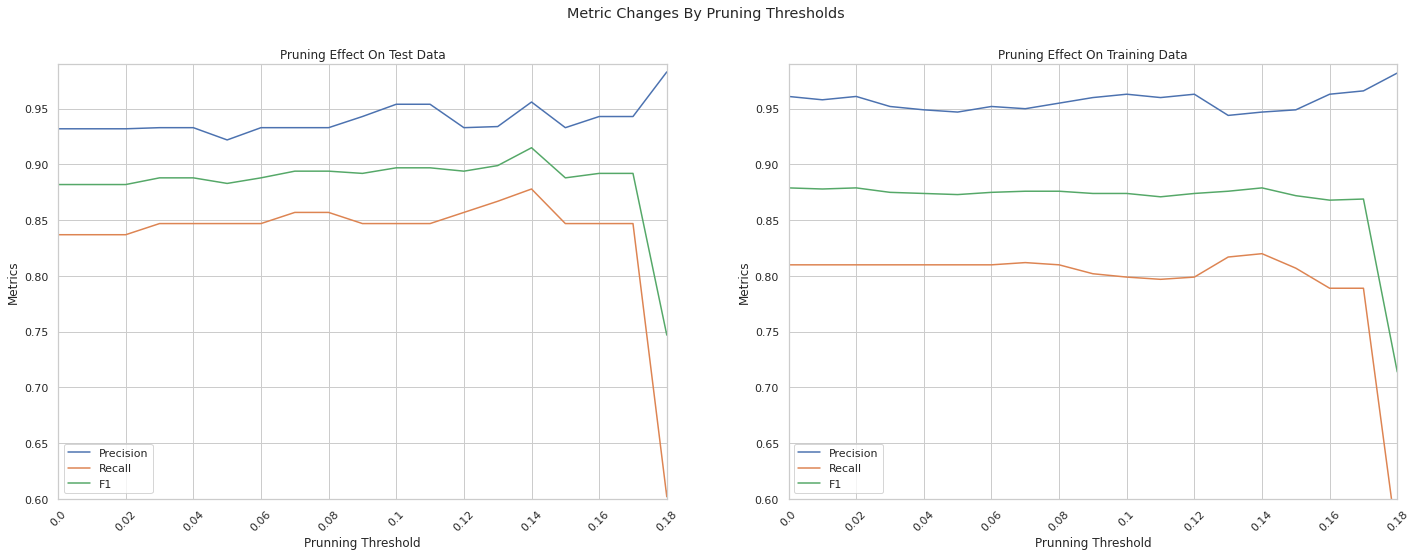

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(24,8))
fig.suptitle('Metric Changes By Pruning Thresholds')
thresholdArray=np.round(thresholdArray,2)

prec=[element['Precision'].item() for idx, element in enumerate(prunningArrayTest)]
axs[0].plot(thresholdArray,[element['Precision'].item() for idx, element in enumerate(prunningArrayTest)],label = "Precision")
axs[0].plot(thresholdArray,[element['Recall'].item() for idx, element in enumerate(prunningArrayTest)],label = "Recall")
axs[0].plot(thresholdArray,[element['F1'].item() for idx, element in enumerate(prunningArrayTest)],label = "F1")
axs[0].legend(loc=3)
axs[0].set_xlabel('Prunning Threshold')
axs[0].set_ylabel('Metrics')
axs[0].set_title('Pruning Effect On Test Data')
axs[0].set_xticks(thresholdArray[::2])
axs[0].set_xticklabels(thresholdArray[::2], rotation=45)
axs[0].set_ylim(0.60,0.99)
axs[0].set_xlim(0.00,0.18)

axs[1].plot(thresholdArray,[element['Precision'].item() for idx, element in enumerate(prunningArrayTrain)],label = "Precision")
axs[1].plot(thresholdArray,[element['Recall'].item() for idx, element in enumerate(prunningArrayTrain)],label = "Recall")
axs[1].plot(thresholdArray,[element['F1'].item() for idx, element in enumerate(prunningArrayTrain)],label = "F1")


#plt.plot(thresholdArray,prunningArray,label = "Test Data F1")
axs[1].set_xticks(thresholdArray[::2])
axs[1].set_xticklabels(thresholdArray[::2], rotation=45)

axs[1].set_xlim(0.00,0.18)
axs[1].set_ylim(0.60,0.99)

axs[1].set_xlabel('Prunning Threshold')
axs[1].set_ylabel('Metrics')
axs[1].legend(loc=3)
axs[1].set_title('Pruning Effect On Training Data')
fig.savefig("prunning.png")

INFO:tensorflow:Assets written to: ram://e56bd985-a57c-43a1-a057-416f4908fd2d/assets
13255
Testing With Fold: 0

Mean Results

Standart Deviation Results



""


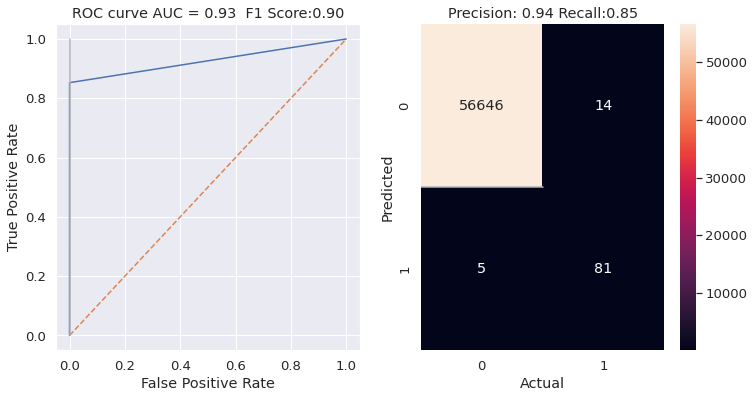

In [ ]:
modelfoldNumber=0
loadName=F"vae_batchSize_200_PE_True_16_8_LD_12_epochs_50_Fold_{modelfoldNumber}"
modelX=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/VariationalAutoEncoder64_32')
w1,modelX=pruneModel(modelX,0.10)
history=trainModelForFold(modelX,modelfoldNumber,epoch=5)

w2,modelX=pruneModel(modelX,0.10)
history=trainModelForFold(modelX,modelfoldNumber,epoch=5)

w3,modelX=pruneModel(modelX,0.10)
history=trainModelForFold(modelX,modelfoldNumber,epoch=5)

print(len(w1))
print(len(w2))
print(len(w3))

testModelForFold(modelX,modelfoldNumber,rocCurve=True,printResults=True)

# rEvaluation= EvalAndPrint(m.Model,dataX,dataY,False)


In [ ]:
dfResults.to_latex()

In [ ]:
print(len(arr1),' weights set to zero at first prunning')
print(len(arr2),' weights set to zero at second prunning')
print(len(arr3),' weights set to zero at third prunning')

14895  weights set to zero at first prunning
11861  weights set to zero at second prunning
11694  weights set to zero at third prunning


In [ ]:
unionWeights=[x for x in arr1 or x in arr2 or x in arr3]
print(len(unionWeights), ' weights set to zero are exists at least one of three prunnings')

intersectionWeights=[x for x in arr1 if x in arr2 and x in arr3]

print(len(intersectionWeights), ' weights set to zero are common for all three prunnings')
print(intersectionWeights)

y=[x for x in arr1 if x in arr2]
print(len(y), ' weights set to zero are common for first and second prunnings')
print(y)

y=[x for x in arr2 if x in arr3]
print(len(y), ' weights set to zero are common for second and third prunnings')
print(y)


14895  weights set to zero are exists at least one of three prunnings
10904  weights set to zero are common for all three prunnings
[['encoder_dense_1', 0, 1], ['encoder_dense_1', 0, 8], ['encoder_dense_1', 0, 9], ['encoder_dense_1', 0, 12], ['encoder_dense_1', 0, 13], ['encoder_dense_1', 0, 14], ['encoder_dense_1', 0, 16], ['encoder_dense_1', 0, 25], ['encoder_dense_1', 0, 31], ['encoder_dense_1', 0, 35], ['encoder_dense_1', 0, 47], ['encoder_dense_1', 0, 48], ['encoder_dense_1', 0, 49], ['encoder_dense_1', 0, 50], ['encoder_dense_1', 0, 52], ['encoder_dense_1', 0, 59], ['encoder_dense_1', 0, 60], ['encoder_dense_1', 0, 61], ['encoder_dense_1', 0, 63], ['encoder_dense_1', 1, 1], ['encoder_dense_1', 1, 8], ['encoder_dense_1', 1, 14], ['encoder_dense_1', 1, 24], ['encoder_dense_1', 1, 29], ['encoder_dense_1', 1, 31], ['encoder_dense_1', 1, 33], ['encoder_dense_1', 1, 34], ['encoder_dense_1', 1, 37], ['encoder_dense_1', 1, 38], ['encoder_dense_1', 1, 41], ['encoder_dense_1', 1, 47], ['en

In [ ]:
m=Mock()
loadName=F"sae_OS_0_PE_True_16_8_LD_10_epochs_15_Fold_{modelfoldNumber}"
m.Model=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{originalModelName}')
print('Original Model Test Results:')
# testModelForAllFolds(m.Model)
arr=[]
for modelLayer in m.Model.layers:
    if (modelLayer.name=='encoder' or modelLayer.name=='decoder' or modelLayer.name=='classifier'):
      layerNumber=0
      for layer in modelLayer.layers:
        if (layer.name.startswith('dense')):
          layerNumber=layerNumber+1
          weights=layer.get_weights()[0]
          biases =layer.get_weights()[1]
          # print(weights.shape)
          # print(biases.shape)
          for i in range(weights.shape[0]):
            for j in range(weights.shape[1]):
              if (weights[i][j]!=0):
                 xName=modelLayer.name + '_dense_' +str(layerNumber)
                 if [xName,i,j] in unionWeights:
                    weights[i][j]=0
                    arr.append([xName,i,j])
          layer.set_weights([weights,biases])
print('Prunned Model Test Results:')
# testModelForAllFolds(m.Model)
trainModelForFold(m.Model,modelfoldNumber,epoch=15)
print('Prunned And Retrained Model Test Results:')
testModelForAllFolds(m.Model)


In [ ]:
# testModelForAllFolds(m.Model,True)
m.Model.save("model.h5")

In [ ]:
unionPrunningModelName="unionPrunning"

m.Model.save(F'{saveToFolder}/{loadName}/{unionPrunningModelName}')

##Evaluate With A  Subset OF Validation Data

In [ ]:
indices = np.where(valY==0)
normalIndexes = r.choice(indices[0], size=10000, replace=False)

indices = np.where(valY==1)
frdIndexes =r.choice(indices[0], size=95, replace=False)

concatIndexes=np.concatenate([frdIndexes,normalIndexes])



EvalAndPrint(m.Model,valX[concatIndexes],valY[concatIndexes])
predictions = m.Model.predict(valX[concatIndexes])
predictions = sklearn.preprocessing.binarize(predictions[1],  threshold=0.5, copy=True)
drawROCCurve(valY[concatIndexes],predictions,'',savePath=F"{saveToFolder}/{m.Model._name}_fold0/{m.Model._name}_confusion.png")


##Evaluate With All Validation Data

In [ ]:

EvalAndPrint(m.Model,valX,valY,True)

predictions = m.Model.predict(valX)
predictions = sklearn.preprocessing.binarize(predictions[1],  threshold=0.5, copy=True)
drawROCCurve(valY,predictions,'',savePath=None)


In [ ]:
#m.Model.save(F'{saveToFolder}/{loadName}/SemiSupervisedAEWithClassifier_ThirdPrunning')


##Test Models

In [ ]:
dfResults=pd.DataFrame()
selectedModels=[('sae_OS_0_PE_True_16_8_LD_10_epochs_15',2)]
for modelKey in selectedModels:
  m=foldModels[modelKey]
  X=m.Model.scaler.transform(X)
  latentPredictions=m.EncoderModel.predict(X)
  print(latentPredictions)
  if m.modelType in ['rf','mlp','sae','vae']:
    y_pred=m.Model.predict(t)
    if (m.modelType in ['mlp']):
        y_pred = (y_pred>0.50)
    if (m.modelType in ['sae','vae']):
        y_pred = ( y_pred[1] > 0.50)
    
    m.results= getResults(m.modelType,m,y_pred,o,m.settings)
    dfResults=pd.concat([dfResults,m.results], axis=0,ignore_index=True)

  # summarize history for loss
  plt.plot(m.TrainHistory['loss'])
  plt.plot(m.EvaluationMetrics['loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train-loss', 'test-loss'], loc='upper right')
  plt.show()      
  
  print(m.EvaluationMetrics)

  plt.plot(m.TrainHistory['classifier_loss'])
  plt.plot(m.EvaluationMetrics['classifier_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train-classifier-loss','test-classifier-loss'], loc='upper right')
  plt.show()     
  
    
# dfResults=dfResults.sort_values(by=['F1'], ascending=False,ignore_index=True)
# print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))
#dfResults.to_excel('/content/drive/My Drive/CreditCardFraudDetection/results.xlsx')

# for i in [55,110,23,45]:
#    dfResults=pd.DataFrame()
#    for mp in mPool:    
#     t,o=createUnderSampledTestSet(i)
#     t,o = PrepareDataForTraining(t,o,positionalEncoding=mp.settings['positionalEncoding'])
#     for key in mp.models:
#       y_pred=mp.models[key].predict(t)
#       if (key in ['mlp']):
#           y_pred = (y_pred>0.50)
#       if (key in ['sae','vae']):
#           y_pred = ( y_pred[1] > 0.50)
      
#       df= getResults(mp.models[key],y_pred,o,mp.settings)
#       dfResults=pd.concat([dfResults,df], axis=0,ignore_index=True)
#       dfResults=dfResults.sort_values(by=['F1'], ascending=False,ignore_index=True)

#     dfResults.to_excel('/content/drive/My Drive/CreditCardFraudDetection/results_'+str(i)+'.xlsx')
#    #dfResults=dfResults.sort_values(by=['F1'], ascending=False,ignore_index=True)
#    #print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))

## Original Model All Folds Tests

In [ ]:
originalModelName="FirstPrunningBeforeTraining"

dfResults=pd.DataFrame()
folds=[0,1,2,3,4]
for fold in folds:
  loadName=F"sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_16_Fold_3"
  m=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/{originalModelName}')
  results=testModelForFold(m,fold,False,False)
  results['ModelName'] = loadName
  dfResults=pd.concat([dfResults,results], axis=0,ignore_index=True)
  

    
# dfResults=np.round(dfResults.groupby('ModelName').mean(),2)
# print(tabulate((pd.DataFrame.from_dict(globalSettings, orient='index')),headers='keys', tablefmt='fancy_grid'))

print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))



Testing With Fold: 0
Testing With Fold: 1
Testing With Fold: 2
Testing With Fold: 3
Testing With Fold: 4
╒════╤══════════╤═══════════════╤══════════════════╤═════════════╤══════════╤═══════╤═════════════════════════════════════════════════════════════════════════════════════════════╕
│    │     Loss │   DecoderLoss │   ClassifierLoss │   Precision │   Recall │    F1 │ ModelName                                                                                   │
╞════╪══════════╪═══════════════╪══════════════════╪═════════════╪══════════╪═══════╪═════════════════════════════════════════════════════════════════════════════════════════════╡
│  0 │ 0.110846 │      0.108087 │       0.00275944 │       0.93  │    0.808 │ 0.865 │ sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_16_Fold_3 │
├────┼──────────┼───────────────┼──────────────────┼─────────────┼──────────┼───────┼──────────────────────────────────────────────────────────────────────────────────────────

╒══════════════════════════════╤════════╕
│                              │ 0      │
╞══════════════════════════════╪════════╡
│ FoldCount                    │ 5      │
├──────────────────────────────┼────────┤
│ RandomState                  │ 16     │
├──────────────────────────────┼────────┤
│ Scaling                      │ MinMax │
├──────────────────────────────┼────────┤
│ BatchSize                    │ 100    │
├──────────────────────────────┼────────┤
│ PositionalEncoding           │ True   │
├──────────────────────────────┼────────┤
│ ValidationDataCount          │ 56961  │
├──────────────────────────────┼────────┤
│ ValidationDataCountPositives │ 98     │
├──────────────────────────────┼────────┤
│ TrainDataCount               │ 227846 │
├──────────────────────────────┼────────┤
│ TrainDataCountPositives      │ 394    │
├──────────────────────────────┼────────┤
│ OversamplingRate             │ 0      │
╘══════════════════════════════╧════════╛


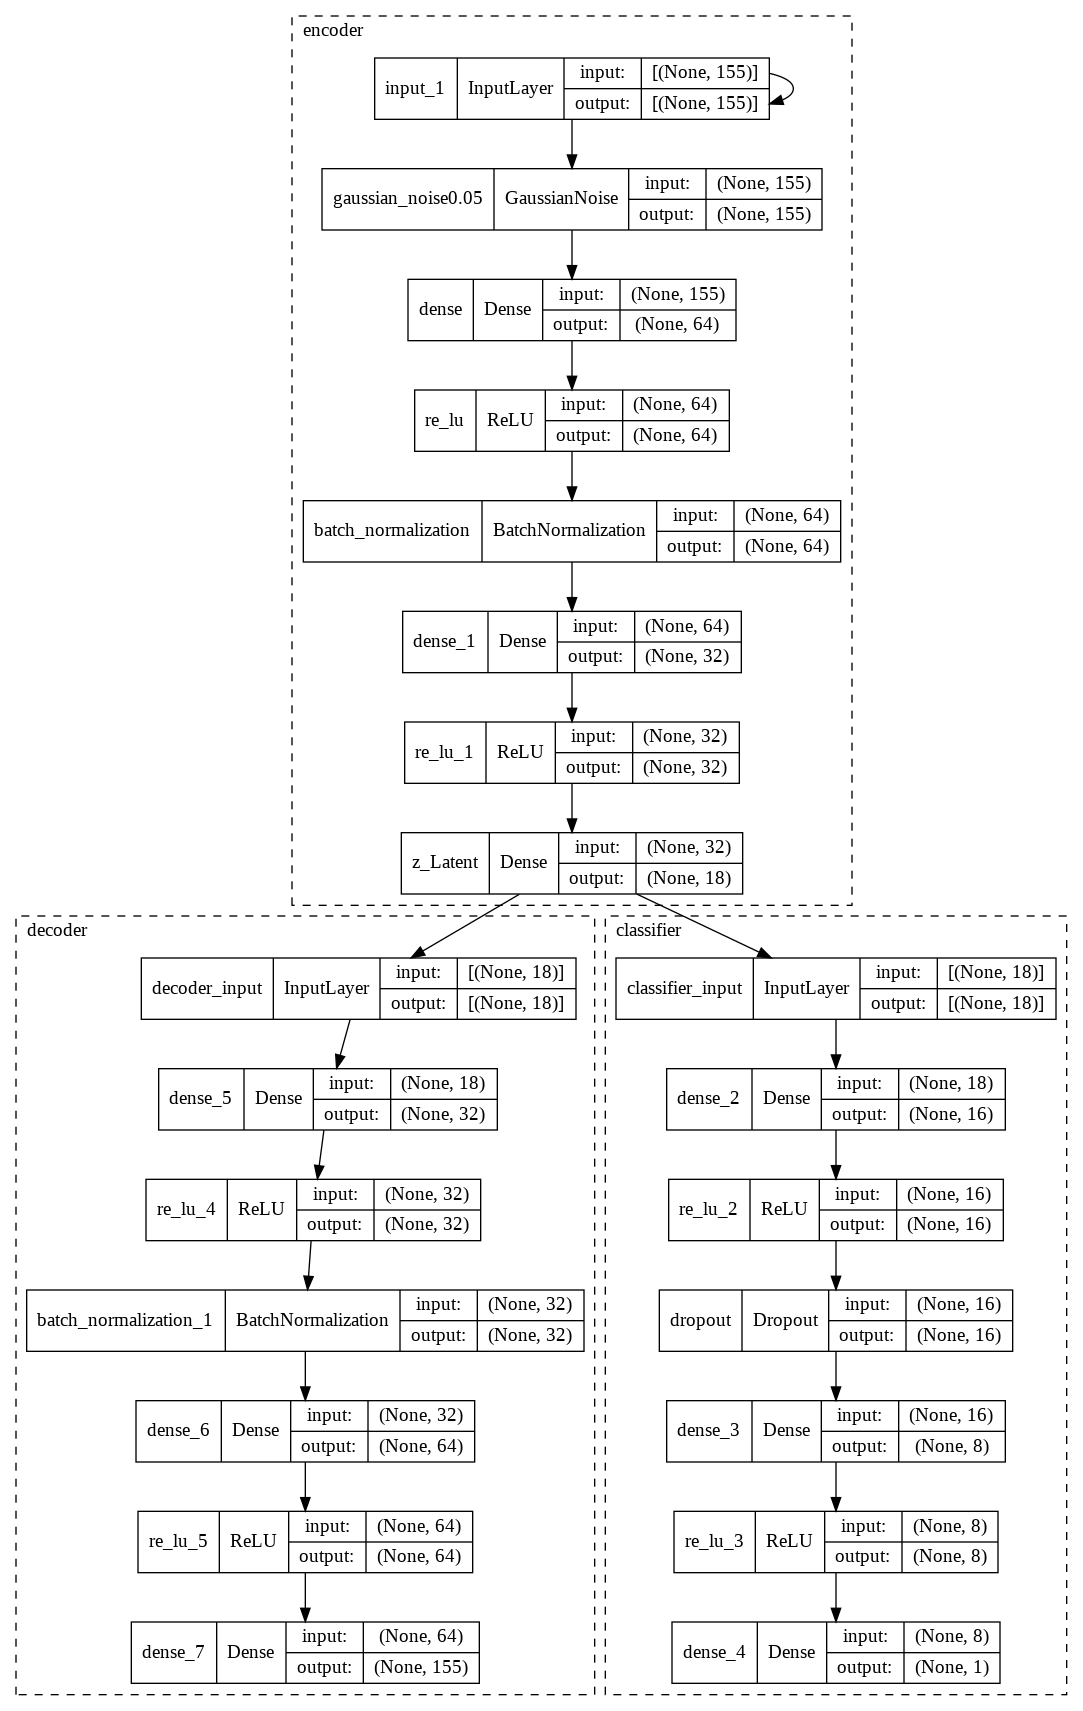

In [ ]:
print(tabulate((pd.DataFrame.from_dict(globalSettings, orient='index')),headers='keys', tablefmt='fancy_grid'))
PlotModel(m.Model)

In [ ]:
import pickle
from keras.models import model_from_json

r=Mock()
modelName="SAE_fold1"
model=tf.keras.models.load_model(F'{saveToFolder}/{modelName}/model/model.h5')
r.Model=model
r.GlobalSettings=pickle.load(open(F"{saveToFolder}/{modelName}/GlobalSettings.pkl", 'rb'))
r.Settings=pickle.load(open(F"{saveToFolder}/{modelName}/Settings.pkl", 'rb'))
r.EvaluationMetrics=pickle.load(open(F"{saveToFolder}/{modelName}/EvaluationMetrics.pkl", 'rb'))
r.TrainHistory=pickle.load(open(F"{saveToFolder}/{modelName}/TrainHistory.pkl", 'rb'))

t= ApplyPositionalEncoding(testX)

p=model.predict(t)
p=(p[1]>0.5)
df= getResults('sae',r.Model,p,testY,r.Settings,r.TrainHistory,r.GlobalSettings)

print(tabulate(df, headers='keys', tablefmt='fancy_grid'))
drawROCCurve(testY,p,r.Model._name)


#Apply PCA or TSNE To Encoder

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1473 samples in 0.001s...
[t-SNE] Computed neighbors for 1473 samples in 0.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1473
[t-SNE] Computed conditional probabilities for sample 1473 / 1473
[t-SNE] Mean sigma: 1.432757
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.905838
[t-SNE] KL divergence after 1000 iterations: 1.073289
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1473 samples in 0.000s...
[t-SNE] Computed neighbors for 1473 samples in 0.157s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1473
[t-SNE] Computed conditional probabilities for sample 1473 / 1473
[t-SNE] Mean sigma: 2.531681
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.639992
[t-SNE] KL divergence after 1000 iterations: 1.049329
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1473 samples in 0.000s...
[t-SNE] Computed neighbors for 1473 samples in 0

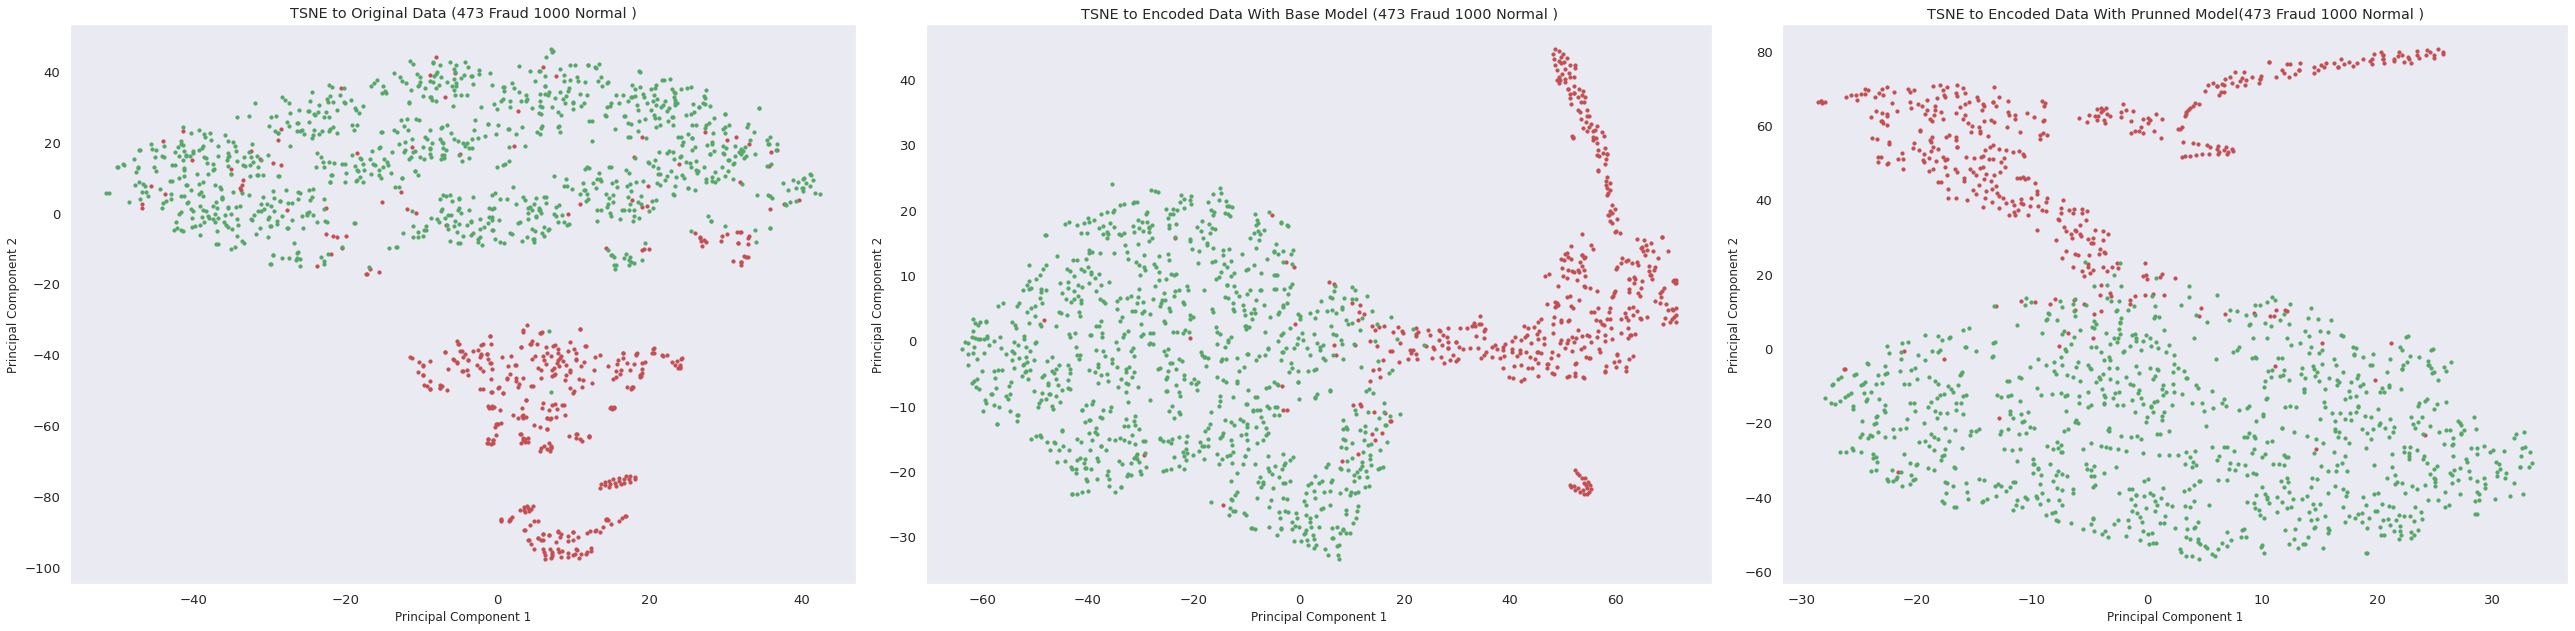

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tf.keras.backend.clear_session()
r=np.random.RandomState(_randomState)

method='TSNE'
dim=2

loadName="sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_16_Fold_3"
loadedModelPrunned=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/FirstPrunningBeforeTraining')
loadedModelBase=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/BaseModel')

for modelLayer in loadedModelPrunned.layers:
  if(modelLayer.name=='encoder'):
    encoderPrunned=modelLayer

for modelLayer in loadedModelBase.layers:
  if(modelLayer.name=='encoder'):
    encoderBase=modelLayer

indices = np.where(dataY==0)
dataX = np.array(dataX)

normalIndexes = r.choice(indices[0], size=1000, replace=False)

indices = np.where(dataY==1)
frdIndexes =r.choice(indices[0], size=473, replace=False)
concatIndexes=np.concatenate([frdIndexes,normalIndexes])
xSamples= ApplyPositionalEncoding(dataX[concatIndexes])
ySamples=np.array(dataY)[concatIndexes].reshape(-1,1)


encodedWithPrunnedXSamples=encoderPrunned.predict(xSamples)

encodedWithBaseXSamples=encoderBase.predict(xSamples)


reducedOriginalData=None
reducedEncodedData=None
caption=None
if (method=='TSNE'):
  captionO = 'TSNE to Original Data (' +  str(len(frdIndexes)) + ' Fraud ' + str(len(normalIndexes)) + ' Normal ' +')'
  captionBE = 'TSNE to Encoded Data With Base Model (' +  str(len(frdIndexes)) + ' Fraud ' + str(len(normalIndexes)) + ' Normal ' + ')'
  captionPE = 'TSNE to Encoded Data With Prunned Model(' +  str(len(frdIndexes)) + ' Fraud ' + str(len(normalIndexes)) + ' Normal ' + ')'

  tsne = TSNE(n_components=dim, verbose=1)
  reducedOriginalData = tsne.fit_transform(xSamples) 
 
  tsnePrunned = TSNE(n_components=dim, verbose=1)
  reducedEncodedDataWithPrunning = tsnePrunned.fit_transform(encodedWithPrunnedXSamples) 

  tsneBase = TSNE(n_components=dim, verbose=1)
  reducedEncodedDataWithBase = tsneBase.fit_transform(encodedWithBaseXSamples) 

if (method=='PCA'):
  captionO = 'PCA to Original Data (', len(frdIndexes), ' Fraud' , len(normalIndexes) , ' Normal ', ')'
  captionBE = 'PCA to Encoded Data With Base Model  (', len(frdIndexes), ' Fraud' , len(normalIndexes) , ' Normal ', ')'
  captionPE = 'PCA to Encoded Data With Prunned Model (', len(frdIndexes), ' Fraud' , len(normalIndexes) , ' Normal ', ')'

  pcax = PCA(n_components=dim, verbose=1)
  reducedOriginalData = pcax.fit_transform(xSamples) 
  
  pcax = PCA(n_components=dim, verbose=1)
  reducedEncodedDataWithPrunning = pcax.fit_transform(encodedWithPrunnedXSamples) 

  
  pcax = PCA(n_components=dim, verbose=1)
  reducedEncodedDataWithBase = pcax.fit_transform(encodedWithBaseXSamples) 



if(dim==2):
  fig, axes = plt.subplots(1,3,figsize=(36,9))
  Draw2DPlot(axes[0],reducedOriginalData,ySamples,captionO)
  Draw2DPlot(axes[1],reducedEncodedDataWithBase,ySamples,captionBE)
  Draw2DPlot(axes[2],reducedEncodedDataWithPrunning,ySamples,captionPE)

  plt.tight_layout()
else:
  fig, axes = plt.subplots(1,3,figsize=(27,9),subplot_kw=dict(projection='3d'))
  Draw3DPlot(axes[0],reducedOriginalData,ySamples,captionO)
  Draw3DPlot(axes[1],reducedEncodedData,ySamples,captionPE)
  Draw3DPlot(axes[2],reducedEncodedData,ySamples,captionBE)

  plt.tight_layout()

In [ ]:
t,o= PrepareDataForTraining(trainX,trainY.ravel(),positionalEncoding=True)
rep_x=restoredMmodel.predict(t)
clf = TrainRandomForest(rep_x,o)
rep_test=mp.models['sae_encoder'].predict(testX)
pred_y = clf.predict(rep_test)
drawROCCurve(testY.reshape(-1,1),pred_y.reshape(-1,1),'RandomForest')


In [ ]:
p=restoredMmodel.predict(t)
#https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e
precisions, recalls, thresholds = precision_recall_curve(o,p[1])
fscores = (2 * precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(fscores)

print(thresholds[optimal_idx], fscores[optimal_idx])


def threshold_from_desired_precision(self, X, y, desired_precision=0.9):
    y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    desired_precision_idx = np.argmax(precisions >= desired_precision)
    return thresholds[desired_precision_idx], recalls[desired_precision_idx]

def threshold_from_desired_recall(self, X, y, desired_recall=0.9):
    y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    desired_recall_idx = np.argmin(recalls >= desired_recall)
    return thresholds[desired_recall_idx], precisions[desired_recall_idx]

def default_cost_function(tn, fp, fn, tp):
    cost = 0
    
    cost += (tn * -10000) 
    cost += (fp * 1000) 
    cost += (fn * 1500) 
    cost += (tp * -20000) 
    
    return cost
def threshold_from_cost_function(self, X, y, cost_function):
    y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

    costs = []
    tns = []
    fps = []
    fns = []
    tps = []
    
    for threshold in thresholds:
        y_pred_with_threshold = (y_scores >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred_with_threshold).ravel()
        costs.append(cost_function(tn, fp, fn, tp))
        tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)

    df_cost = pd.DataFrame({'precision':precisions[:-1], 'recall':recalls[:-1], 'threshold':thresholds, 'cost':costs, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})
    
    min_cost = df_cost['cost'].min()
    threshold = df_cost[df_cost['cost']==min_cost].iloc[0]['threshold']

    return threshold, min_cost, df_cost




##Compare Models

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


dfResults=pd.DataFrame()

for mp in mPool:
  for t,o in [(testX,testY)]:
    t,o = PrepareDataForTraining(t,o,positionalEncoding=mp.settings['positionalEncoding'])
    for key in mp.models:
        y_pred=mp.models[key].predict(t)
        if (key in ['mlp']):
            y_pred = (y_pred>0.50)
        if (key in ['sae','vae']):
            y_pred = ( y_pred[1] > 0.50)
      
        mp.models[key].results= getResults(key,mp.models[key],y_pred,o,mp.settings)
        dfResults=pd.concat([dfResults,mp.models[key].results], axis=0,ignore_index=True)
       
    
dfResults=dfResults.sort_values(by=['F1'], ascending=False,ignore_index=True)
print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))
dfResults.to_excel('/content/drive/My Drive/CreditCardFraudDetection/results.xlsx')

for i in [55,110,23,45]:
   dfResults=pd.DataFrame()
   for mp in mPool:    
    t,o=createUnderSampledTestSet(i)
    t,o = PrepareDataForTraining(t,o,positionalEncoding=mp.settings['positionalEncoding'])
    for key in mp.models:
      y_pred=mp.models[key].predict(t)
      if (key in ['mlp']):
          y_pred = (y_pred>0.50)
      if (key in ['sae','vae']):
          y_pred = ( y_pred[1] > 0.50)
      
      df= getResults(mp.models[key],y_pred,o,mp.settings)
      dfResults=pd.concat([dfResults,df], axis=0,ignore_index=True)
      dfResults=dfResults.sort_values(by=['F1'], ascending=False,ignore_index=True)

    dfResults.to_excel('/content/drive/My Drive/CreditCardFraudDetection/results_'+str(i)+'.xlsx')
   #dfResults=dfResults.sort_values(by=['F1'], ascending=False,ignore_index=True)
   #print(tabulate(dfResults, headers='keys', tablefmt='fancy_grid'))



In [ ]:
print(mp.models[key].results['F1'][0])

In [ ]:
from sklearn.metrics import classification_report
#modelKey='mlp'
for mp in mPool:
  dfResults=pd.DataFrame()
  for t,o in [(testX,testY)]:
    t,o = PrepareDataForTraining(t,o,positionalEncoding=mp.settings['positionalEncoding'])
    for key in mp.models:
        y_pred=mp.models[key].predict(t)
        if (key in ['mlp']):
            y_pred = (y_pred>0.50)
        if (key in ['sae','vae']):
            y_pred = ( y_pred[1] > 0.50)
        drawROCCurve(testY,y_pred,models[key]._name)
        #print(classification_report(testY,y_pred))
 

In [ ]:
# EvalAndPrint(m.Model,valX,valY,printDf=True)
testModelForAllFolds(m.Model):

# Other

In [ ]:
_positionalEncoding=False
nextInput = encoder.predict(X)
testInput = encoder.predict(testX)
valInput=encoder.predict(validationX)
if (_positionalEncoding):
  testInput=getInputExtended(testInput)
  nextInput=getInputExtended(nextInput)
  valInput=getInputExtended(valInput)
deepX=get_Standart(nextInput.shape[1],neuronCounts=[64,32])
deepX.fit(nextInput,	y={"classifier": Y},
                validation_data=(valInput,{ "classifier": validationY}),
                epochs=50,
                verbose=1,
                batch_size=32,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
              )

In [ ]:
testInputEncoded= encoder.predict(testX)
if (_positionalEncoding):
  testInputEncoded=getInputExtended(testInputEncoded)
resultsDeep=deepX.predict(testInputEncoded)
resultsDeep = ( resultsDeep> 0.50)
printResults(resultsDeep,testY)

In [ ]:
results=encoder.predict(testInputArray)


pca=PCA(3)
r = pca.fit_transform(results[2])

Draw3DPlot(r,testOutputArray.reshape(-1,1))

In [ ]:
from tensorflow import keras
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.classifier=classifier
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker =tf. keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:

_neuronCounts=[64,32]
_latentDim=12
_neuronCountsForClassifier=[32,16]
_trainDataCount=0
_testDataCount=0
_trainDataCountPositives=0
_testDataCountsPositives=0
_maxEpochs=50
_patience=3
_batch_size=32
_verbose=0


def get_Variational_Encoder(numInputColumns,neuronCounts=[],latent_dim=0):

  inputLayer = Input(shape = (numInputColumns,))
  x=inputLayer
  counter=0
  # Iteratively add the hidden layers
  for n_neurons in neuronCounts:
      counter=counter+1
      x = Dense(n_neurons)(x)
      x = ReLU()(x)
      if(counter==1):
        x = BatchNormalization()(x)

  z_mean = Dense(latent_dim, name="z_mean")(x)
  z_log_var = Dense(latent_dim, name="z_log_var")(x)
  zSample =Sampling()((z_mean, z_log_var))
  
  encoder = Model(inputLayer,[z_mean, z_log_var, zSample])

  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  l=latent_inputs
  for n_neurons in reversed(neuronCounts):
    counter=counter+1
    l = Dense(n_neurons)(l)
    l = ReLU()(l)
 
  dOut  = Dense(numInputColumns, activation='relu')(l)
  decoder = Model(latent_inputs, dOut, name='decoder')

  # instantiate VAE model
  
  encoderOut=encoder(inputLayer)
  decoderOut=decoder(encoderOut[2])

  vae = Model(inputLayer,[decoderOut], name='vae_mlp')
  kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
  vae.add_loss(kl_loss) 

  vae._name ='VariationalAutoEncoder_Seperated_Outputs'  + '_'.join([str(elem) for elem in neuronCounts]) 
  vae.add_metric(kl_loss, 'kl_loss')
  vae.compile(loss={
                                 'decoder':'mse'
                              },
              loss_weights=[1,0.5],
                       optimizer=tf.keras.optimizers.Adam())
 
  return vae,encoder,decoder

  
indices = np.where(trainY==1)
X=np.array(trainX)[indices]
Y=np.array(trainY)[indices]


vae,encoder,decoder=get_Variational_Encoder(X.shape[1],neuronCounts=_neuronCounts,latent_dim=_latentDim)

vae._name='VAE_' + '_inShape_' + str(X.shape[1])  + '_' +  '_'.join([str(elem) for elem in _neuronCounts]) + '_L_'+str(_latentDim)  
history = vae.fit(X,	y={"decoder":X},
                                validation_data=(X,{"decoder":X}),
                                epochs=100,
                                verbose=1,
                                batch_size=32,
                                callbacks=  [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

In [ ]:
cv = StratifiedKFold(n_splits=4, random_state = _randomState, shuffle=True)
foldCount=0
for train_indexes,validation_indexes in cv.split(trainX,trainY):
  foldCount=foldCount+1
  X = trainX[train_indexes]
  Y = trainY[train_indexes].reshape(-1,1)

  valX=trainX[validation_indexes]
  valY=trainY[validation_indexes]
  # random_vector_for_generation = tf.random.normal(shape=[10000, _latentDim])
  # predictedX=decoder.predict(random_vector_for_generation)



  # Y=np.concatenate((Y,np.ones(predictedX.shape[0]).reshape(-1,1)),axis=0)
  # X=np.concatenate((X,predictedX),axis=0)
  X,Y=overSampleData(X,Y,'SMOTE',0.06,_randomState)
  X, Y = shuffle(X, Y,random_state =_randomState)
  print('train -  {}   |   validation -  {}'.format(np.bincount(Y.astype(int).ravel()), np.bincount(valY.astype(int).ravel())))


  vae2,encoder2=get_Auto_Encoder_With_Classifier(X.shape[1],neuronCountsForEncoder=_neuronCounts,latent_dim=_latentDim,neuronCountsClassifier=_neuronCountsForClassifier)
  vae2._name='AE_' + '_inShape_' + str(X.shape[1])  + '_' +  '_'.join([str(elem) for elem in _neuronCounts]) + '_L_'+str(_latentDim)  
  history = vae2.fit(X,	y={"decoder":X,"classifier":Y},
                                  validation_data=(valX,{"decoder":valX,"classifier":valY}),
                                  epochs=50,
                                  verbose=1,
                                  batch_size=32,
                                  callbacks=  [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

  )
  if (foldCount>0):
          break

In [ ]:
y_pred=vae2.predict(np.array(testX))

y_pred = ( y_pred[1] > 0.50)
drawROCCurve(testY,y_pred,vae2._name)
settings={}
        
settings['oversamplingRate']=0
settings['oversamplingMethod']=None
settings['positionalEncoding']=False
settings['trainDataCount']=_trainDataCount
settings['trainDataCountPositives']=_trainDataCountPositives
settings['randomState']=_randomState
settings['scaling']=_scaling
df=getResults(vae2,y_pred,testY,settings)
print(df)

In [ ]:
print(y_pred[1][:100])

##TSNE

In [ ]:
from sklearn.manifold import TSNE

# np.random.seed(42)
# pca = PCA(n_components=3)
tsne = TSNE(n_components=3, verbose=1, random_state=42)

# indices = np.where(trainY==0)
# normalIndexes = np.random.choice(indices[0], size=5000, replace=False)
# indices = np.where(trainY==1)
# frdIndexes = np.random.choice(indices[0], size=312, replace=False)
# concatIndexes=np.concatenate([frdIndexes,normalIndexes])

#input=inputArray[concatIndexes]
#z = pca.fit_transform(input)
z = tsne.fit_transform(results[2]) 


Draw3DPlot(z,testOutputArray.reshape(-1,1))


In [ ]:
PlotModel(deepModel)


In [ ]:

resultPredict=deepModel.predict(testX)
resultPredicted = ( resultPredict > 0.5)



printResults(resultPredicted,testY)


In [ ]:
PlotModel(autoEncoderModel)

#Threshold Defining

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_true = np.array([0,0, 1, 1,1])
y_scores = np.array([0.0,0.09, .05, .75,1])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_true, y_scores))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

#Save Models

In [ ]:
import pickle
for i,j in foldModels:
  modelHolder=foldModels[(i,j)]
  if (modelHolder.ModelType!='rf' and  not modelHolder.Name.count("decoder")>>0 ):
    m=modelHolder.Model
    m._name="SAE"
    tf.keras.models.save_model(m,F"{saveToFolder}/{m._name}_fold{j}/model/model.h5",save_format="h5")
    pickle.dump(modelHolder.Settings, open(F"{saveToFolder}/{m._name}_fold{j}/Settings.pkl", 'wb'))
    pickle.dump(modelHolder.GlobalSettings, open(F"{saveToFolder}/{m._name}_fold{j}/GlobalSettings.pkl", 'wb'))
    pickle.dump(modelHolder.EvaluationMetrics, open(F"{saveToFolder}/{m._name}_fold{j}/EvaluationMetrics.pkl", 'wb'))
    pickle.dump(modelHolder.TrainHistory, open(F"{saveToFolder}/{m._name}_fold{j}/TrainHistory.pkl", 'wb'))
    print(m._name)





In [ ]:
import pickle
def SaveSpecial(model,f1,settings,globalSettings,evaluationMetrics,history):
    model.save(F"{saveToFolder}/{m.Name}.tf")
    pickle.dump(settings, open(F"{saveToFolder}/{m.Name}_Settings.pkl", 'wb'))
    pickle.dump(globalSettings, open(F"{saveToFolder}/{m.Name}_GlobalSettings.pkl", 'wb'))
    pickle.dump(evaluationMetrics, open(F"{saveToFolder}/{m.Name}_EvaluationMetrics.pkl", 'wb'))
    pickle.dump(history, open(F"{saveToFolder}/{m.Name}_TrainHistory.pkl", 'wb'))
    print(m.Name)

In [ ]:
SaveSpecial(foldModels[(i,j)].Model,foldModels[(i,j)].Settings,df["F1"].iloc[0])

#AutoEncoder & Deep After

In [ ]:
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
from sklearn.model_selection import StratifiedKFold

_neuronCounts=[128,64]
_latentDim=16

autoEncoderModel=None

cv = StratifiedKFold(n_splits=5, random_state = 42, shuffle=True)
foldCount=0
for train_indexes,validation_indexes in cv.split(inputArray,  outputArray):
  K.clear_session()
  foldCount=foldCount+1
  print(F"-----------fold: {foldCount} training----------")

  X = inputArray[train_indexes]
  Y=  outputArray[train_indexes]
  valX=inputArray[validation_indexes]
  valY=outputArray[validation_indexes]
  autoEncoderModel,encoder=get_Auto_Encoder_Vanilia(X.shape[1],neuronCountsForEncoder=_neuronCounts,latent_dim=_latentDim)
  history = autoEncoderModel.fit (X,	y={ "decoder":X},
            validation_data=(valX,{"decoder":valX}),
            epochs=50,
            verbose=1,
            batch_size=32,
            callbacks=  [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                patience=3
                              )])
  if (foldCount>0):
   break

In [ ]:
selectedModels=[('sae_OS_0_PE_True_16_8_LD_12_epochs_10',1)]
m_Encoder=foldModels[modelKey].EncoderModel

encodedX = m_Encoder.predict(X)

In [ ]:
encodedX = encoder.predict(X)
encodedValX=encoder.predict(valX)
deepModel=get_Standart(encodedX.shape[1],neuronCounts=[32,16])
history= deepModel.fit (encodedX,Y,
            validation_data=(encodedValX,valY),
            epochs=50,
            verbose=1,
            batch_size=32,
            callbacks=  [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                patience=3
                              )])

testEncoded=encoder.predict(testInputArray)


predictions=deepModel.predict(testEncoded)
predictions = ( predictions > 0.5)

printResults(predictions,testOutputArray)

In [ ]:
from sklearn.utils import shuffle

cv = StratifiedKFold(n_splits=4, random_state = _randomState, shuffle=True)
foldCount=0
for train_indexes,validation_indexes in cv.split(trainX,trainY):
  foldCount=foldCount+1
  X = trainX[train_indexes]
  Y = trainY[train_indexes].reshape(-1,1)

  valX=trainX[validation_indexes]
  valY=trainY[validation_indexes]
  random_vector_for_generation = tf.random.normal(shape=[492, _latentDim])
  predictedX=decoder.predict(random_vector_for_generation)



  Y=np.concatenate((Y,np.ones(predictedX.shape[0]).reshape(-1,1)),axis=0)
  X=np.concatenate((X,predictedX),axis=0)
  # X,Y=overSampleData(X,Y,'SMOTE',1,_randomState)
  X, Y = shuffle(X, Y,random_state =_randomState)
  print('train -  {}   |   validation -  {}'.format(np.bincount(Y.astype(int).ravel()), np.bincount(valY.astype(int).ravel())))

  deepModel=get_MLP(X.shape[1],neuronCounts=[16,8])

  history= deepModel.fit (X,Y,
              validation_data=(valX,valY),
              epochs=50,
              verbose=1,
              validation_batch_size=32,
              batch_size=32,
              callbacks=  [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  patience=3
                                )])
  if (foldCount>0):
    break


In [ ]:
drawLossHistory(history)


#Latent Space Random Forest

In [ ]:
m=Mock()
a=ApplyPositionalEncoding(trainX)
_latentDim=10
_neuronCountsForClassifier=[16,8]
_neuronCountsForEncoder=[64,32]
m.Model,m.EncoderModel,m.DecoderModel= get_Auto_Encoder_With_Classifier(a.shape[1],_latentDim,_neuronCountsForClassifier,_neuronCountsForEncoder)
print(a.shape)

history = m.Model.fit (a,	[a ,trainY ],
                             
                              epochs=15,
                              verbose=1,
                              batch_size=200)

m.Model.evaluate(ApplyPositionalEncoding(testX),testY)



In [ ]:
saePredictions=sklearn.preprocessing.binarize(m.Model.predict(ApplyPositionalEncoding(testX))[1], threshold=0.5, copy=False) 
drawROCCurve(testY,saePredictions,'SAE Predictions')


# trainLatentPredicted=m.EncoderModel.predict(ApplyPositionalEncoding(trainX))
# testLatentPredicted=m.EncoderModel.predict(ApplyPositionalEncoding(testX))

# rf=TrainRandomForest(trainLatentPredicted,trainY) #train rf

# rfPredictions=rf.predict(testLatentPredicted)
# drawROCCurve(testY,rfPredictions,'RandomForest')

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(testLatentPredicted)
y_kmeans = kmeans.predict(testLatentPredicted)
# plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
data = pd.DataFrame(testLatentPredicted)
data['cluster'] = y_kmeans
pd.plotting.parallel_coordinates(data, 'cluster')
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
from sklearn.manifold import MDS
import seaborn as sns

embedding = MDS(n_components=2)
mds = pd.DataFrame(embedding.fit_transform(testLatentPredicted),
             columns = ['component1','component2'])
mds['cluster'] = kmeans.predict(testLatentPredicted)

sns.scatterplot(data=mds,x = "component1",y="component2",hue="cluster")


In [ ]:
m.Model.save(F"{saveToFolder}/{m.Model._name}")
a=tf.keras.models.load_model(F"{saveToFolder}/{m.Model._name}")
PlotModel(a)

In [ ]:
predictions=deepModel.predict(testX)
predictions = ( predictions > 0.5)
drawROCCurve(testY,predictions,'')
df=getResults(deepModel,predictions,testY,settings)
print(df)

In [ ]:
modelfoldNumber=3
loadName=F"sae_inSize155_batchSize_100_PE_True_64_3216_8_LD_18_epochs_20_gn005_duplicated_rs_s_16_Fold_{modelfoldNumber}"
modelX=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/BaseModel/')
#trainX,trainY,valX,valY=splitFolds(modelfoldNumber,5,16)
# print(valX.shape)
#resultsSummary=testModelForFold(modelX,modelfoldNumber,False,False)
#print(resultsSummary.head(1))
#scores=modelX.predict(valX)[1]
#predictions = sklearn.preprocessing.binarize(scores,  threshold=0.5, copy=True)
#drawROCCurve(valY,predictions,'res')
#EvalAndPrint(modelX,valX,valY)
#mx1=tf.keras.models.load_model(F'{saveToFolder}/{loadName}/BaseModel')
#resultsSummary=testModelForFold(mx1,modelfoldNumber,False,False)
#print(resultsSummary)
# normalSamplesError=[];
# normalSamplesIndexes=[];
# fraudSamplseIndexes=[]
# fraudSamplesError=[]



# for index, (value1, value2) in enumerate(zip(valX[np.where(valY==1)][:98], valY[np.where(valY==1)][:98])):
#   scores=modelX.evaluate(x=value1.reshape(-1,155), y={'decoder': value1.reshape(-1,155), 'classifier': value2.reshape(-1,1)},verbose=0)
#   evalResult = pd.DataFrame(np.array([scores]), columns=modelX.metrics_names)
#   fraudSamplesError.append(evalResult['decoder_loss'])
#   fraudSamplseIndexes.append(index)

# for index, (value1, value2) in enumerate(zip(valX[np.where(valY==0)][:500], valY[np.where(valY==0)][:500])):
#   scores=modelX.evaluate(x=value1.reshape(-1,155), y={'decoder': value1.reshape(-1,155), 'classifier': value2.reshape(-1,1)},verbose=0)
#   evalResult = pd.DataFrame(np.array([scores]), columns=modelX.metrics_names)
#   normalSamplesError.append(evalResult['decoder_loss'])
#   normalSamplesIndexes.append(index)



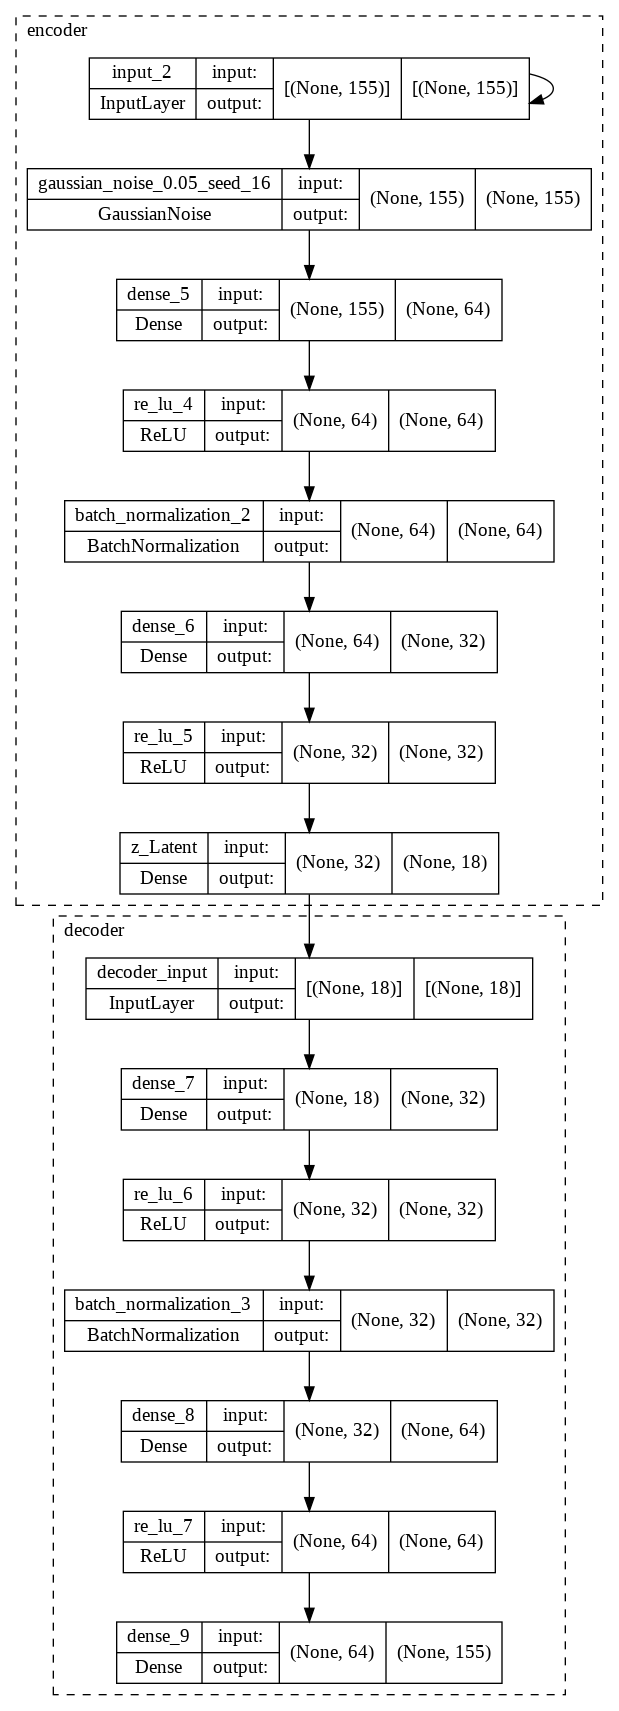

In [ ]:
PlotModel(modelVanilia)

In [ ]:
from keras.callbacks import EarlyStopping
modelfoldNumber=3
trainX,trainY,valX,valY=splitFolds(modelfoldNumber,5,16)
es = EarlyStopping(monitor='val_loss',patience=10,mode='min')
modelVanilia,vanEnc,vanDec=get_Auto_Encoder_Vanilia(155,[64,32],18)
_maxEpochs=50
_verbose=1
_batch_size=100
print(trainY[0])
normalIndexesTrainData=np.where(trainY==0)
trainXNormal=trainX[normalIndexesTrainData]
normalIndexesValidationData=np.where(valY==0)
validationXNormal=valX[normalIndexesValidationData]
history = modelVanilia.fit (trainXNormal,	trainXNormal,
                                                      validation_data=(validationXNormal,{"decoder":validationXNormal}),
                                                      epochs=_maxEpochs,
                                                      verbose=_verbose,
                                                      batch_size=_batch_size,
                            callbacks=[es])

0
Epoch 1/50
2275/2275 [==============================] - 17s 7ms/step - loss: 0.2522 - val_loss: 0.2443
Epoch 2/50
2275/2275 [==============================] - 13s 6ms/step - loss: 0.2436 - val_loss: 0.2436
Epoch 3/50
2275/2275 [==============================] - 10s 4ms/step - loss: 0.2429 - val_loss: 0.2426
Epoch 4/50
2275/2275 [==============================] - 10s 4ms/step - loss: 0.2426 - val_loss: 0.2428
Epoch 5/50
2275/2275 [==============================] - 10s 5ms/step - loss: 0.2424 - val_loss: 0.2428
Epoch 6/50
2275/2275 [==============================] - 10s 5ms/step - loss: 0.2421 - val_loss: 0.2422
Epoch 7/50
2275/2275 [==============================] - 10s 4ms/step - loss: 0.2418 - val_loss: 0.2416
Epoch 8/50
2275/2275 [==============================] - 10s 5ms/step - loss: 0.2417 - val_loss: 0.2415
Epoch 9/50
2275/2275 [==============================] - 11s 5ms/step - loss: 0.2417 - val_loss: 0.2414
Epoch 10/50
2275/2275 [==============================] - 10s 4ms/step -

In [ ]:
scores=modelX.predict(x=valX)
mse = np.mean(np.power(valX - scores[0], 2), axis=1)
fraudIndexes=  np.where(valY==1)
normalIndexes= np.where(valY==0)

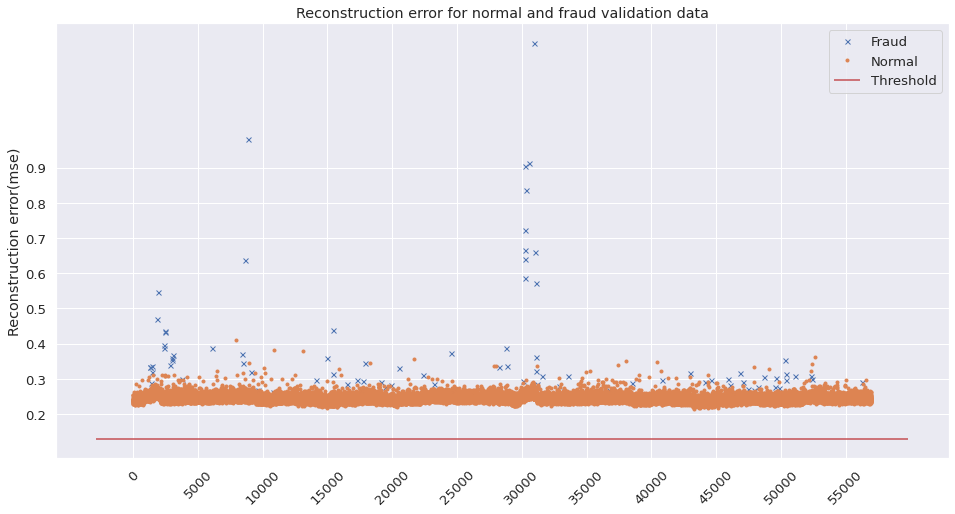

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.array(fraudIndexes).reshape(-1,1), mse[fraudIndexes], marker='x', ms=5, linestyle='',
            label= "Fraud")
ax.plot(np.array(normalIndexes).reshape(-1,1), mse[normalIndexes], marker='o', ms=3, linestyle='',
            label= "Normal")
threshold_fixed=0.13
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
ax.set_title("Reconstruction error for normal and fraud validation data")
ax.set_ylabel("Reconstruction error(mse)")
ax.set_xticks(np.arange(0, len(valX), 5000))
ax.set_yticks(np.arange(0.20, 0.95, 0.10))
ax.set_xticklabels(np.arange(0, len(valX),5000), rotation=45)
fig.show();

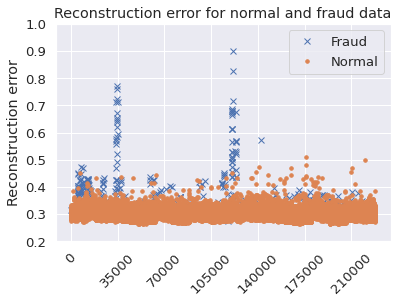

In [ ]:
scores=modelX.predict(x=trainX)
mse = np.mean(np.power(trainX - scores[0], 2), axis=1)

fraudIndexes=  np.where(trainY==1)
normalIndexes= np.where(trainY==0)

fig, ax = plt.subplots()
ax.plot(np.array(fraudIndexes).reshape(-1,1), mse[fraudIndexes], marker='x', ms=5.5, linestyle='',
            label= "Fraud")
ax.plot(np.array(normalIndexes).reshape(-1,1), mse[normalIndexes], marker='o', ms=3.5, linestyle='',
            label= "Normal")


ax.legend()
ax.set_title("Reconstruction error for normal and fraud data")
ax.set_ylabel("Reconstruction error")
ax.set_xticks(np.arange(0, len(trainX), 35000))
ax.set_yticks(np.arange(0.20, 1.05, 0.10))
ax.set_xticklabels(np.arange(0, len(trainX),35000), rotation=45)

fig.show();

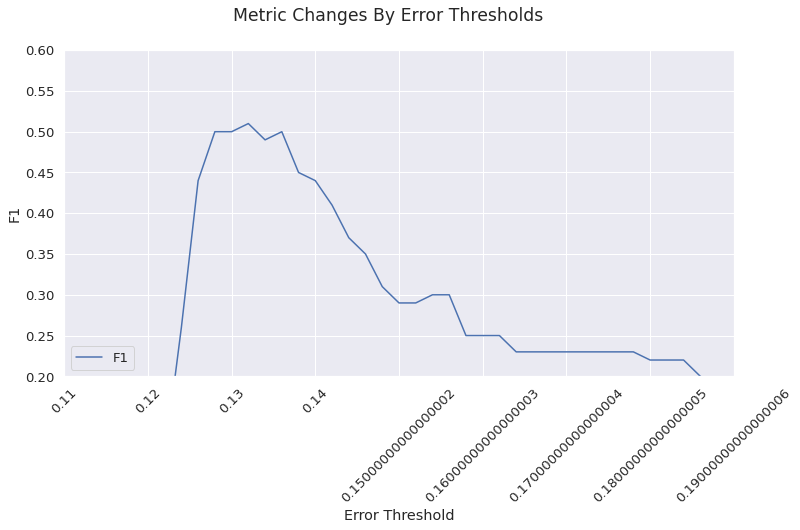

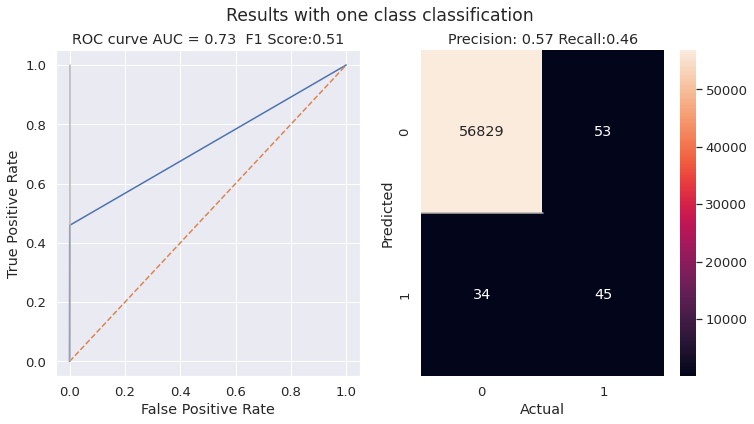

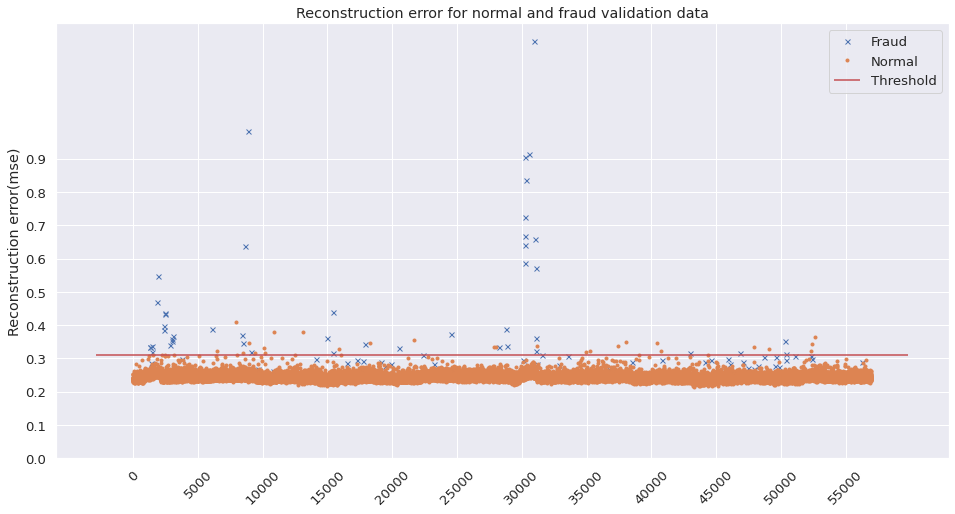

In [ ]:
xActual = valX
yActual = valY

scores=modelX.predict(x=xActual)
mse = np.mean(np.power(xActual - scores[0], 2), axis=1)


f1List=[]
thresholdArray=[]
thresholdx =0.10
while thresholdx<0.60:
  thresholdx+=0.01
  pred_y = [1 if e > thresholdx else 0 for e in mse]
  f1List.append(np.round(sklearn.metrics.f1_score(yActual,pred_y),2))
  thresholdArray.append(thresholdx)

fig, axs = plt.subplots(1,1,figsize=(12,6))
fig.suptitle('Metric Changes By Error Thresholds')

axs.plot(thresholdArray,[element for idx, element in enumerate(f1List)],label = "F1")
axs.legend(loc=3)
axs.set_xlabel('Error Threshold')
axs.set_ylabel('F1')
ax.set_xticks(np.array(thresholdArray))
axs.set_xticklabels(np.array(thresholdArray), rotation=45)
axs.set_ylim(0.20,0.60)
axs.set_xlim(0.20,0.60)
fig.show()

thresholdMax= np.array(thresholdArray)[np.argmax(np.array(f1List))]

yPred = [1 if e > thresholdMax else 0 for e in mse]
drawROCCurve(yActual,yPred,'Results with one class classification')



fraudIndexes=  np.where(yActual==1)
normalIndexes= np.where(yActual==0)

scores=modelX.predict(x=xActual)
mse = np.mean(np.power(xActual - scores[0], 2), axis=1)


fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.array(fraudIndexes).reshape(-1,1), mse[fraudIndexes], marker='x', ms=5, linestyle='',
            label= "Fraud")
ax.plot(np.array(normalIndexes).reshape(-1,1), mse[normalIndexes], marker='o', ms=3, linestyle='',
            label= "Normal")
ax.hlines(thresholdMax, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
ax.set_title("Reconstruction error for normal and fraud validation data")
ax.set_ylabel("Reconstruction error(mse)")
ax.set_xticks(np.arange(0, len(valX), 5000))
ax.set_yticks(np.arange(0, 1, 0.10))
ax.set_xticklabels(np.arange(0, len(valX),5000), rotation=45)
fig.show();

In [ ]:
print(valY.shape)


(56961,)
